In [1]:
%load_ext autoreload
%autoreload 2
import re
from pathlib import Path
import pywt
import somoclu
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib import cm, font_manager, gridspec
from mne.time_frequency import morlet
from scipy.signal import find_peaks, decimate
from scipy.stats import skew, entropy, zscore, ttest_ind, linregress
from scipy.optimize import curve_fit
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression

from readers.mat_files import MatRecordingsParser
from detectors.shw import SharpWavesFinder
import clustering as clustering
import utils as utils
from scipy.io import savemat, loadmat

In [2]:
# set paper font
font_dirs = ['/usr/share/fonts/truetype/myriad-pro-regular']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = 'Myriad Pro'

In [3]:
bad_recordings_old = [
    ('SA05', 'SA05_SA06_19_04_21__Trial12_Trial9_30D'),
    ('SA05', 'SA05_SA06_20_04_21_Trial13_Trial10_33D'),
    ('SA05', 'SA05_SA06_02_05_21_Trial23_Trial20_35D'),
    ('SA05', 'SA05_SA06_13_04_21_Trial8_Trial5_24D_2021-04-13_17-55-14'),
    ('SA05', 'SA5_SA6'),
    ('SA06', 'SA05_SA06_27_04_21_Trial20_Trial17_27D'),
    ('SA07', 'SA07_SA05_15_05_21_Trial03_Trial30_27D'),
    ('SA06', 'SA05_SA06_06_05_21_Trial26_Trial23_27D'),
    ('SA06', 'SA05_SA06_03_05_21_Trial24_Trial21_27D'),
]
bad_recordings = [
    ('SA04', 'SA4_02_04_21_Trial16_3M6_21D_2021-04-02_15-56-59'),
    ('SA05', 'SA05_SA06_18_04_21_Trial11_Trial08_18D'),
    ('SA05', 'SA05_SA06_19_04_21__Trial12_Trial9_30D'),
    ('SA05', 'SA05_SA06_15_04_21_Trial10_Trial7_18D'),
    ('SA06', 'SA05_SA06_15_04_21_Trial10_Trial7_18D'),
    ('SA05', 'SA05_SA06_14_04_21_Trial9_Trial6_18D'),
    ('SA06', 'SA05_SA06_14_04_21_Trial9_Trial6_18D'),
    ('SA06', 'SA05_SA06_22_04_21_Trial15_Trial12_35D'),
    ('SA06', 'SA05_SA06_23_04_21_Trial16_Trial13_35D'),
    ('SA05', 'SA05_SA06_24_04_21__Trial17_Trial1418D'),
    ('SA06', 'SA05_SA06_24_04_21__Trial17_Trial1418D'),
    ('SA06', 'SA05_SA06_26_04_21_Trial19_Trial16_27D'),
    ('SA05', 'SA05_SA06_28_04_21_Trial21_Trial18_21D'),
    ('SA06', 'SA05_SA06_28_04_21_Trial21_Trial18_21D'),
    ('SA06', 'SA05_SA06_29_04_21_Trial22_Trial19_21D'),
    ('SA05', 'SA05_SA06_02_05_21_Trial23_Trial20_35D'),
    ('SA05', 'SA05_SA06_11_04_21_Trial6_Trial3_3M6_24D_2021-04-11_17-13-28'),
    ('SA07', 'SA09_SA07_04_06_21_Trial2_Trial16_30D'),
    ('SA09', 'SA9_SA7_15_06_21_Trial9_Trial23_24D'),
    ('SA09', 'SA07_SA09_21_06_21_Trial14_Trial28_35D'),
    ('SA09', 'SA07_SA09_23_06_21_Trial16_Trial30_18D'),
    ('SA07', 'SA07_SA09_28_06_21_Trial19_Trial33_18D'),
    ('SA09', 'SA07_SA09_03_07_21_Trial22_Trial36_21D'),
]

In [3]:
mats = list(Path('/media/sil2/Data/Lizard/Stellagama').rglob(f'decimate_rec_*.mat')) + list(Path('/media/sil1/Stellagama').rglob(f'decimate_rec_*.mat'))
len(mats)

109

In [4]:
with open('../output/template_filter.np', 'rb') as f:
    tmpl = np.load(f)

In [ ]:
%%time
p = mats[82]
i = p.name.find('SA')
animal_id = p.name[i:i+4]
rec_id = -4 if p.parts[-3].startswith('Record') else -3
rec_name = p.parts[rec_id]
name = (animal_id, rec_name)
rp = MatRecordingsParser(p.parent.parent.as_posix(), channel=None, is_debug=True, animal_id=animal_id, mat_only=True,
                         window=600, overlap=0.75, wavelet=None, lowpass=40)

Loading .mat file...
Buffered Matrix size: (438, 240000)
Number of segments after buffering: 438
start creation of sig_df...


  0%|          | 0/438 [00:00<?, ?it/s]

Number of sharp waves found: 133586
start creation of sig_df...


  0%|          | 0/133586 [00:00<?, ?it/s]

start ShW checking...
CPU times: user 10min 49s, sys: 44.7 s, total: 11min 34s
Wall time: 3min 40s


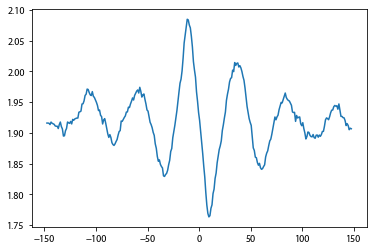

In [69]:
%%time
swf = SharpWavesFinder(rp, shw_duration=0.8)
swf.train(mfilt=tmpl[::-1], thresh=0.25)
r, t, _ = swf.calc_cycle_sw_rate(wt=20, group_length=150)
# rf = swf.calc_sw_rate(60*60, overlap=0.75, label=None, lights_off_only=True)
plt.plot(t[2:-2]-t[-1]/2, r[2:-2]/20)

# of slow waves: 132


[array([  6.86464941,  -5.18071247, -10.80219465, ..., -36.96442065,
        -48.06035128, -55.43338563])]

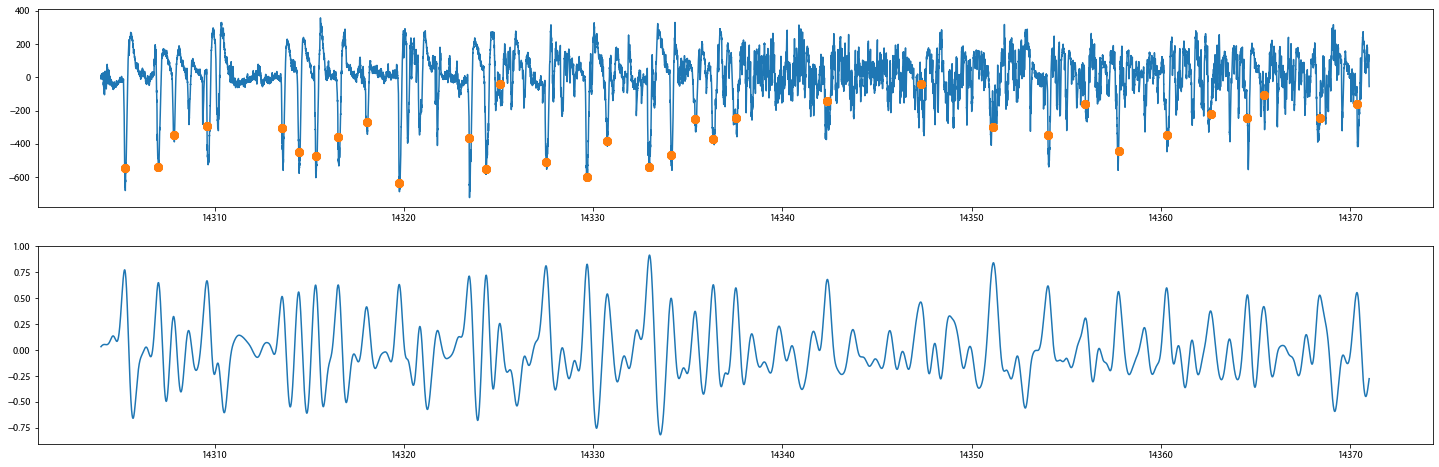

In [70]:
swf.plot_cycle_with_sharp_waves(0)

In [5]:
# new loop
rates = {}
all_nights = {}
temps = {}
sw_dfs = {}
for p in tqdm(mats):
    try:
        i = p.name.find('SA')
        animal_id = p.name[i:i+4]
        rec_id = -4 if p.parts[-3].startswith('Record') else -3
        rec_name = p.parts[rec_id]
        name = (animal_id, rec_name)
        rp = MatRecordingsParser(p.parent.parent.as_posix(), channel=None, is_debug=False, animal_id=animal_id,mat_only=True, window=600, overlap=0.75, wavelet=None, lowpass=40)
        swf = SharpWavesFinder(rp, shw_duration=1.2, is_debug=False)
        swf.train(mfilt=tmpl[::-1], thresh=0.25)
        r, t, _ = swf.calc_cycle_sw_rate(wt=20, group_length=150)
        rf = swf.calc_sw_rate(60*60, overlap=0.75, label=None, lights_off_only=True)
        rates[name] = r
        all_nights[name] = rf
        temps[name] = rp.temp
        sw_dfs[name] = swf.shw_df.copy()
    except Exception as exc:
        print(f'ERROR; {exc}; {p}')

temps = {k: v for k, v in sorted(temps.items(), key=lambda item: item[1])}

  0%|          | 0/109 [00:00<?, ?it/s]

ERROR; Out of bounds nanosecond timestamp: 1-01-01 19:00:00; /media/sil2/Data/Lizard/Stellagama/SA5_SA6/SA05_SA06_13_04_21_Trial8_Trial5_24D_2021-04-13_17-55-14/Record Node 116/regev_cache/decimate_rec_SA05.mat
ERROR; Out of bounds nanosecond timestamp: 1-01-01 19:00:00; /media/sil2/Data/Lizard/Stellagama/SA5_SA6/SA05_SA06_13_04_21_Trial8_Trial5_24D_2021-04-13_17-55-14/Record Node 116/regev_cache/decimate_rec_SA06.mat
ERROR; int() argument must be a string, a bytes-like object or a number, not 'NoneType'; /media/sil2/Data/Lizard/Stellagama/SA5_SA6/SA05_SA06_28_04_21_Trial21_Trial18_21D/Record Node 116/regev_cache/decimate_rec_SA06.mat


In [39]:
d = {
    'cycle_t': t,
    'cycles_rates': rates,
    'all_nights': all_nights,
    'temps': temps,
    'sw_dfs': sw_dfs,
    'avg_shw_shapes': V
}
savemat('../output/stella_figures/cache.mat', d, do_compression=True)

In [44]:
import pickle

with open('../output/stella_figures/cache.pkl', 'wb') as f:
    pickle.dump(d, f)

In [45]:
with open('../output/stella_figures/cache.pkl', 'rb') as f:
    dd = pickle.load(f)

dd

{'cycle_t': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 17

Statistics for width vs. temp: r^2=0.501,p-value=4e-12, corr=-0.708,p-value=4e-12
Statistics for depth vs. temp: r^2=0.404,p-value=2e-09, corr=0.636,p-value=2e-09


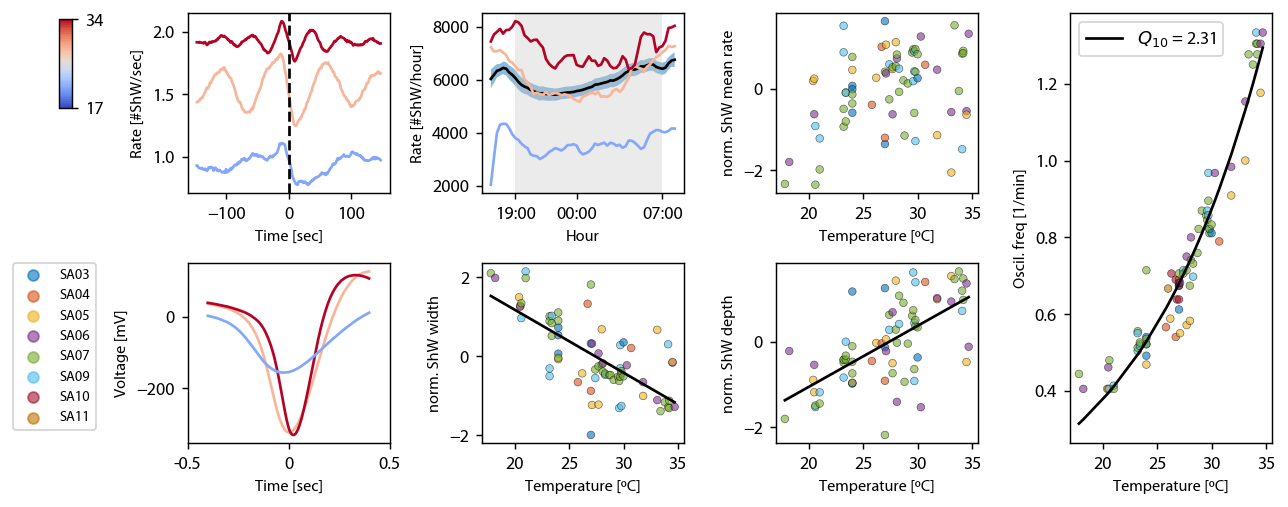

In [50]:
from plotters.stellagama import StellaPlotter

StellaPlotter().temperature_figure()

t=17.168 , P=9.0e-38
CPU times: user 10min 46s, sys: 55.3 s, total: 11min 41s
Wall time: 3min 55s


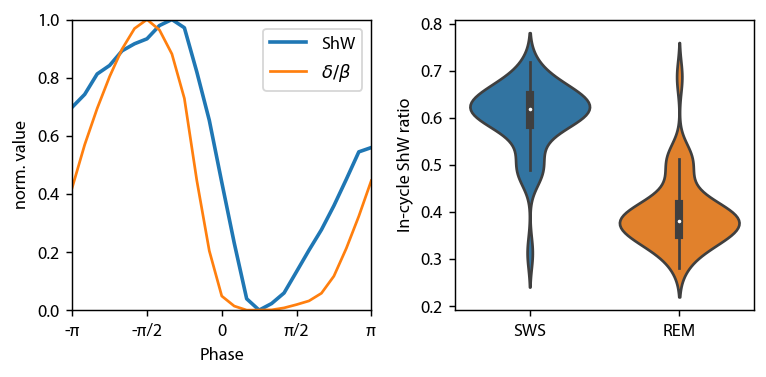

In [54]:
%%time
# sp = StellaPlotter()
# sp.supplementary_figure()
sp.phase_figure()

In [ ]:
shapes = {}
for p in tqdm(mats):
    try:
        i = p.name.find('SA')
        animal_id = p.name[i:i+4]
        rec_name = p.parts[-4]
        name = (animal_id, rec_name)
        # if animal_id in ['SA07', 'SA09']:
        #     continue
        rp = RecordingsParser(p.parent.parent.as_posix(), channel=None, is_debug=False, animal_id=animal_id, mat_only=True)
        swcl = clustering.SharpWavesClusterer(rp, window_time=1.2, cwt_wavelet='morl', is_debug=False)
        swcl.train(rp.v.flatten(), rp.t, thresh=0.15, conv_w=600)
        sf = swcl.sig_df.copy()
        sf.group.fillna(0, inplace=True)
        shapes[animal_id] = []
        for i, row in sf.iterrows():
            shapes[animal_id].append(swcl.parser.v[int(row.start):int(row.end)])
    except Exception as exc:
        print(f'ERROR; {exc}; {p}')

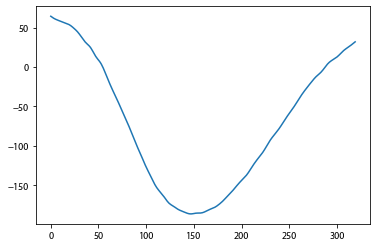

In [506]:
# filter create
tmpl = None
n = 0
for i, row in swcl.sig_df.query('power>0.5 and signal==signal and group>0').iterrows():
    v = swcl.parser.v[row.start:row.end]
    if tmpl is None:
        tmpl = v.copy()
    else:
        tmpl = tmpl + v
    n += 1

tmpl = tmpl / n
plt.plot(tmpl)

with open('template_filter.np', 'wb') as f:
    np.save(f, tmpl)

In [40]:
for i, p in enumerate(mats):
    if 'SA07_AS09_19_06_21_Trial13_Trial27_35D' in p.as_posix():
        print(i)

82


In [57]:
name

('SA07', 'SA07_AS09_19_06_21_Trial13_Trial27_35D')

In [6]:
cycles_compare = [
        ('SA07', 'SA07_SA09_23_06_21_Trial16_Trial30_18D'),
        ('SA07', 'SA07_SA09_17_06_21_Trial11_Trial25_27D'),
        ('SA07', 'SA07_AS09_19_06_21_Trial13_Trial27_35D')
    ]

In [7]:
# Get the average ShW shapes

records = []
for p in mats:
    i = p.name.find('SA')
    animal_id = p.name[i:i+4]
    rec_name = p.parts[-4]
    name = (animal_id, rec_name)
    if name in cycles_compare:
        records.append((p, name))
    # rp = RecordingsParser(p.parent.parent.as_posix(), channel=None, is_debug=False, animal_id=animal_id, mat_only=True)
    # swcl = clustering.SharpWavesClusterer(rp, window_time=1.2, cwt_wavelet='morl', is_debug=False)
    # swcl.train(rp.v.flatten(), rp.t, thresh=0.15, conv_w=600)
    # sf = swcl.sig_df.copy()
V = {}
for p, name in tqdm(records):
    try:
        rp = MatRecordingsParser(p.parent.parent.as_posix(), channel=None, is_debug=False, animal_id=name[0],
                                 mat_only=True, window=600, overlap=0.75, wavelet=None, lowpass=40)
        v_, _ = rp.read()
        sf = sw_dfs[name].copy()
        sf.group.fillna(0, inplace=True)
        V[name] = []
        for i, row in sf.iterrows():
            V[name].append(v_[int(row.start):int(row.end)])
        V[name] = np.vstack(V[name]).mean(axis=0)
    except Exception as exc:
        print(f'ERROR; {exc}; {p}')

  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
# calculate t_cyc for ShW using autocorrelation
def autocorr(x, t, ax=None):
    n = x.size
    norm = (x - np.mean(x))
    result = np.correlate(norm, norm, mode='same')
    acorr = result[n//2 + 1:]
    acorr_norm = result[n//2 + 1:] / (x.var() * np.arange(n-1, n//2, -1))
    lag = np.abs(acorr_norm).argmax() + 1
    r = acorr_norm[lag-1]
    peaks, _ = find_peaks(acorr, prominence=0.1)
    if len(peaks) == 0:
        peaks = [len(acorr)-1]
    t_ = t[n//2 + 1:]
    t_cyc = t_[peaks][0] - t_[0]
    power = acorr[peaks][0] / acorr[0]
    power_norm = acorr_norm[peaks][0] / acorr_norm[0]
    if ax is not None:
        ax.plot(t_, acorr)
        ax.scatter(t_[peaks], acorr[peaks])
        ax.set_title(f'Tcyc = {t_cyc}, power = {power:.2}, power_norm = {power_norm:.2}\nr = {r:.2},  lag={lag}')
    return t_cyc, power, power_norm, r, lag

In [9]:
# cols_names = ['animal_id', 'name', 'temp', 'width', 'total_sw', 'sw_per_cyc', 'max_cyc_rate', 'p2v', 'all_night_avg', 't_cyc', 'power', 'power_norm', 'r', 'lag']
acf = pd.DataFrame()#(columns=cols_names)
for i, (name, temp) in enumerate(temps.items()):
    rate = rates[name]
    sw_df = sw_dfs[name]
    all_night = all_nights[name]
    q = all_night.datetime.dt.strftime('%H:%M:%S')
    all_night = all_night[(q >= '19:00') | (q <= '07:00')]
    acf.loc[i, 'animal_id'] = name[0]
    acf.loc[i, 'name'] = name[1]
    acf.loc[i, 'temp'] = temp
    # auto-correlation
    acf.loc[i, ['t_cyc', 'power', 'power_norm', 'r', 'lag']] = autocorr(rate, t)
    # ShW widths
    acf.loc[i, 'width'] = sw_df.query('power>0.4').width.mean()
    acf.loc[i, 'depth'] = sw_df.query('power>0.4').depth.mean()
    # total ShW
    acf.loc[i, 'total_sw'] = len(sw_df)
    # ShW/cycle
    acf.loc[i, 'sw_per_cyc'] = sw_df.groupby('signal').start.count().mean()
    # max cycle rate value
    acf.loc[i, 'max_cyc_rate'] = rate[:len(rate)//2].max()
    acf.loc[i, 'p2v'] = rate[:len(rate)//2].max() - rate[len(rate)//2:].min()
    acf.loc[i, 'all_night_avg'] = all_night.rate.mean()

    # res = list(name) + [temp, w, total_sw, sw_per_cyc, max_cyc_rate, p2v, all_night_avg] + list(res)
    # acf = acf.append({k: v for k, v in zip(cols_names, res)}, ignore_index=True)

In [35]:
acf

,animal_id,name,temp,t_cyc,power,power_norm,r,lag,width,depth,total_sw,sw_per_cyc,max_cyc_rate,p2v,all_night_avg
0,SA07,SA07_SA09_24_06_21_Trial17_Trial31_18D,17.3,43.0,-0.151080,-0.176456,0.966836,1.0,0.456714,224.159349,104279.0,255.046875,30.265625,2.843750,5357.041667
1,SA05,SA05_SA06_24_04_21__Trial17_Trial1418D,17.5,21.0,0.008260,0.008884,0.960841,1.0,0.508268,62.584824,104658.0,328.527778,32.666667,2.183333,5589.583333
2,SA06,SA05_SA06_24_04_21__Trial17_Trial1418D,17.5,27.0,0.119185,0.131016,0.967795,1.0,0.624001,188.112424,92380.0,110.034014,30.192029,2.278986,5071.854167
3,SA05,SA05_SA06_25_04_21_Trial18_Trial15_18D,17.5,29.0,0.076862,0.085118,0.913394,1.0,0.529152,51.048813,100906.0,365.817518,34.197080,1.795620,6052.104167
4,SA06,SA05_SA06_25_04_21_Trial18_Trial15_18D,17.5,148.0,0.042377,0.083912,0.990420,1.0,0.514049,136.092422,85391.0,260.426471,31.411765,5.323529,5298.354167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,SA07,SA07_AS09_19_06_21_Trial13_Trial27_35D,34.2,37.0,0.335039,0.382354,0.938002,1.0,0.255365,487.128005,170823.0,119.367762,51.269171,1.162754,9164.958333
102,SA07,SA07_SA09_22_06_21_Trial15_Trial29_35D,34.2,43.0,0.426713,0.498388,0.918610,1.0,0.274453,444.211906,155226.0,120.649296,51.440845,0.963380,9202.187500
103,SA06,SA05_SA06_23_04_21_Trial16_Trial13_35D,34.5,49.0,0.507455,0.606917,0.955604,1.0,0.402335,334.629284,86256.0,65.992561,32.065344,1.049008,5494.416667
104,SA05,SA05_SA06_02_05_21_Trial23_Trial20_35D,34.5,51.0,0.617808,0.744857,0.955275,1.0,0.529593,74.419267,97807.0,101.643154,42.677824,2.702929,6065.208333


In [10]:
bad_recordings = [tuple(x) for x in acf.query('power<0.3')[['animal_id', 'name']].to_records(index=False)]

cycle oscillations: corr=0.927, p-value=1e-34
shw widths: r^2=0.501 , p-value=3.62e-12
shw width: corr=-0.708, p-value=4e-12
shw widths: r^2=0.404 , p-value=1.97e-09
shw depth: corr=0.636, p-value=2e-09


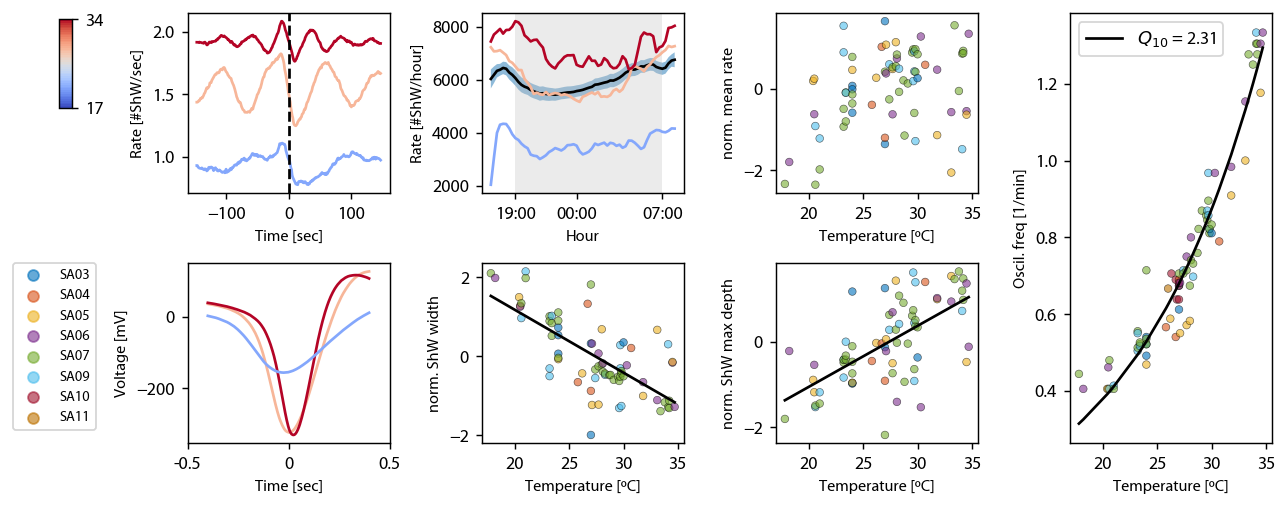

In [38]:
colormap = cm.get_cmap('coolwarm', len(set(temps.values())))
colors = {int(k): colormap(i) for i, k in enumerate(sorted(set(temps.values())))}
animal_colors = {
    'SA03':	(0, 0.447, 0.741),
    'SA04': (0.850, 0.325, 0.098),
    'SA05': (0.929, 0.694, 0.125),
    'SA06': (0.494, 0.184, 0.556),
    'SA07': (0.466, 0.674, 0.188),
    'SA09': (0.301, 0.745, 0.933),
    'SA10': (0.635, 0.078, 0.184),
    'SA11': (0.741, 0.447, 0)
}
ALPHA = 0.6

def plot_sw_around_cycle_trasition(ax=None):
    if ax is None:
        ax = plt.subplot(figsize=(6,3), dpi=140)
    t_ = t[2:-2]-t[-1]/2
    for name, temp in temps.items():
        if name not in cycles_compare:
            continue
        rate = rates[name]
        ax.plot(t_, rate[2:-2]/20, color=colors[int(temp)])
    ax.axvline(0, color='k', linestyle='--')
    # ax.set_title(f'Average rate of sharp-waves for sleep cycle\n around transition point (SWS->REM)\nAll Animals',
    #              fontname='Myriad Pro', fontsize=8)
    ax.set_xlabel('Time [sec]', fontsize=9)
    ax.set_ylabel('Rate [#ShW/sec]', fontsize=9)

def plot_cycle_stats_vs_temp(temps, rates, axes=None):
    assert len(axes) == 2
    temp_vec = []; max_values = []; peak2valleys = []; color_vec = []; animal_ids = []
    for name, temp in temps.items():
        if name in bad_recordings:
            continue
        rate = rates[name]
        max_value = rate[:len(rate)//2].max()
        temp_vec.append(temp)
        max_values.append(max_value)
        peak2valleys.append(max_value - rate[len(rate)//2:].min())
        # color_vec.append(colors[temp])
        animal_ids.append(name[0])
        color_vec.append(animal_colors[name[0]])
    if axes is None:
        fig, axes = plt.subplots(1,2,figsize=(6,3), dpi=140)
    df = pd.DataFrame({'temp': temp_vec, 'max_values': max_values, 'peak2valley': peak2valleys, 'animal_id': animal_ids})
    sns.scatterplot(data=df, x='temp', y='max_values', ax=axes[0], hue='animal_id', palette=animal_colors)
    # sns.regplot(x=temp_vec, y=max_values, ax=axes[0], order=2, scatter_kws=dict(color=color_vec))
    h, l = axes[0].get_legend_handles_labels()
    axes[0].legend([], [], frameon=False)
    axes[0].set_title(f'Max value vs. temperature', fontsize=10)
    axes[0].set_xlabel('Temperature [ºC]', fontsize=9)
    axes[0].set_ylabel('Rate [#sharp-waves/20sec]', fontsize=9)
    # sns.regplot(x=temp_vec, y=peak2valleys, ax=axes[1], order=2, scatter_kws=dict(color=color_vec))
    # sns.scatterplot(x=temp_vec, y=peak2valleys, ax=axes[1], color=color_vec)

    sns.scatterplot(data=df, x='temp', y='peak2valley', ax=axes[1], hue='animal_id', palette=animal_colors)
    axes[1].legend([], [], frameon=False)
    axes[1].set_title(f'Peak-to-Valley vs. temperature', fontsize=10)
    axes[1].set_xlabel('Temperature [ºC]', fontsize=9)
    axes[1].set_ylabel('Rate [#sharp-waves/20sec]', fontsize=9)
    axes[0].grid()
    axes[1].grid()
    # axes[0].legend(labels=animal_colors.keys())
    return h, l

def plot_rate_all_night(ax, only_mid=False, is_legend=None):
    if ax is None:
        ax = plt.subplot(figsize=(6,3), dpi=140)
    for animal_id in ['SA07']:
        averaged = []
        n_recs = 0
        s = {}
        for name, temp in temps.items():
            if name in bad_recordings or name[0] != animal_id:
                continue
            rf = all_nights[name].copy().reset_index()[['rate', 'time', 'datetime']]
            rf.time = rf.time / 3600
            rf.datetime = rf.datetime.dt.strftime('%H:%M')
            rf_vec = rf.set_index('datetime')['rate']
            averaged.append(rf_vec.copy())
            n_recs += 1
            if name in cycles_compare:
                if only_mid and name != ('SA07', 'SA07_SA09_17_06_21_Trial11_Trial25_27D'):
                    continue
                sns.lineplot(data=rf, x='datetime', y='rate', color=colors[int(temp)], ax=ax, label=is_legend and f'{int(temp)}ºC', zorder=10)
        if n_recs == 0:
            continue
        avf = pd.DataFrame(averaged).transpose()
        sns.lineplot(x=avf.index.values, y=avf.mean(axis=1), color='k', ax=ax, label=is_legend and 'Average', ci=None)
        ax.fill_between(avf.index.values, avf.mean(axis=1) - avf.sem(axis=1), avf.mean(axis=1) + avf.sem(axis=1), alpha=0.5)

    # ax.set_title('Rate of sharp-waves across all night\nAll Animal')
    ax.set_xlabel('Hour', fontsize=9)
    ax.set_ylabel('Rate [#ShW/hour]', fontsize=9)
    ax.set_xticks(['19:00', '00:00', '07:00'])
    ax.axvspan('19:00', '07:00', facecolor='silver', alpha=0.3)
    if is_legend:
        h, l = ax.get_legend_handles_labels()
        ax.legend(h, l)
    return averaged

def plot_sw_shapes(ax):
    t_ = np.arange(-0.4, 0.4, 1/400)
    for name, v in V.items():
        temp = temps[name]
        # for g, v in d.items():
        #     if g == 0:
        ax.plot(t_, v, label=f'{temp}', color=colors[int(temp)])
    # ax.legend(title='Temp.', fontsize=8)
    ax.set_xlabel('Time [sec]', fontsize=9)
    ax.set_ylabel('Voltage [mV]', fontsize=9)
    ax.set_xticks([-0.5, 0, 0.5], ['-0.5', '0', '0.5'])

def plot_sw_per_cycle(ax):
    animals = ['SA05', 'SA06', 'SA07']
    g = sns.lineplot(data=cf.query(f'animal_id in {animals}'), x='temp', y='y', hue='animal_id', ax=ax,
                 palette=animal_colors)
    # plt.title('Amount of Sharp-Waves divided by Cycle Length', fontsize=13)
    ax.set_xlabel('Temperature [ºC]', fontsize=9)
    ax.set_ylabel('#SW/Cycle Length [1/sec]', fontsize=9)
    ax.grid()
    ax.legend([], [], frameon=False)

def plot_sw_cycle_oscil_freq(ax):
    T0 = 17
    def q10(T, *P):
        return P[1] * P[0]**((T - T0)/10)

    data = acf.query('power>0.3').copy()
    data['freq'] = 1/(data.t_cyc/60)
    xdata = data['temp'].values
    ydata = data['freq'].values
    p0 = [2.2, 1.7]
    popt, pcov = curve_fit(q10, xdata, ydata, p0=p0)
    sns.scatterplot(data=data, x='temp', y='freq', hue='animal_id', ax=ax, palette=animal_colors, alpha=ALPHA, edgecolor='black', s=18)
    ax.plot(xdata, q10(xdata, *popt), 'k-', label=r'$Q_{10}$' + f' = {popt[0]:.2f}')

    c, p = utils.corrcoef(np.vstack([data.temp.values, data.freq.values]))
    print(f'cycle oscillations: corr={c[0,1]:.3f}, p-value={p[0,1]:.0e}')

    h, l = ax.get_legend_handles_labels()
    ax.legend(h[-1:], l[-1:])
    # ax.set_title('t_cyc', fontsize=10)
    ax.set_xlabel('Temperature [ºC]', fontsize=9)
    ax.set_ylabel('Oscil. freq [1/min]', fontsize=9)
    ax.set_xticks([20, 25, 30, 35])
    return h[:-1], l[:-1]

def plot_sw_widths(ax):
    data = acf.query('power>0.3 and animal_id not in ["SA10","SA11"]').copy()
    col = 'width'
    for animal_id, idx in data.groupby('animal_id').groups.items():
        # data.loc[idx, col] = data.loc[idx, col] / data.loc[idx, col].mean()
        data.loc[idx, col] = (data.loc[idx, col] - data.loc[idx, col].mean()) / data.loc[idx, col].std()
    X = data.temp.values.reshape(-1, 1)
    slope, intercept, r, p, se = linregress(data.temp.values, data[col].values)
    print(f'shw widths: r^2={r**2:.3f} , p-value={p:.3}')


    c, p = utils.corrcoef(np.vstack([data.temp.values, data[col].values]))
    print(f'shw width: corr={c[0,1]:.3f}, p-value={p[0,1]:.0e}')

    sns.scatterplot(data=data, x='temp', y='width', hue='animal_id', ax=ax, palette=animal_colors, alpha=ALPHA, edgecolor='black', s=18)
    ax.plot(X.squeeze(), X.squeeze() * slope + intercept, 'k')
    ax.legend([], [], frameon=False)
    # ax.set_title('ShW Widths', fontsize=10)
    ax.set_xlabel('Temperature [ºC]', fontsize=9)
    ax.set_ylabel('norm. ShW width', fontsize=9)
    ax.legend([], [], frameon=False)
    ax.set_xticks([20, 25, 30, 35])

def plot_sw_depths(ax):
    data = acf.query('power>0.3 and animal_id not in ["SA10","SA11"]').copy()
    col = 'depth'
    for animal_id, idx in data.groupby('animal_id').groups.items():
        # data.loc[idx, col] = data.loc[idx, col] / data.loc[idx, col].mean()
        data.loc[idx, col] = (data.loc[idx, col] - data.loc[idx, col].mean()) / data.loc[idx, col].std()
    X = data.temp.values.reshape(-1, 1)
    slope, intercept, r, p, se = linregress(data.temp.values, data[col].values)
    print(f'shw widths: r^2={r**2:.3f} , p-value={p:.3}')
    c, p = utils.corrcoef(np.vstack([data.temp.values, data[col].values]))
    print(f'shw depth: corr={c[0,1]:.3f}, p-value={p[0,1]:.0e}')
    sns.scatterplot(data=data, x='temp', y=col, hue='animal_id', ax=ax, palette=animal_colors, alpha=ALPHA, edgecolor='black', s=18)
    ax.plot(X.squeeze(), X.squeeze() * slope + intercept, 'k')
    ax.legend([], [], frameon=False)
    # ax.set_title('ShW Widths', fontsize=10)
    ax.set_xlabel('Temperature [ºC]', fontsize=9)
    ax.set_ylabel('norm. ShW max depth', fontsize=9)
    ax.legend([], [], frameon=False)
    ax.set_xticks([20, 25, 30, 35])

def plot_sw_avg_rate(ax):
    data = acf.query('power>0.3 and animal_id not in ["SA10","SA11"]').copy()
    col = 'all_night_avg'
    for animal_id, idx in data.groupby('animal_id').groups.items():
        # data.loc[idx, col] = data.loc[idx, col] / data.loc[idx, col].mean()
        data.loc[idx, col] = (data.loc[idx, col] - data.loc[idx, col].mean()) / data.loc[idx, col].std()
    sns.scatterplot(data=data, x='temp', y=col, hue='animal_id', ax=ax, palette=animal_colors, alpha=ALPHA, edgecolor='black', s=18)
    ax.legend([], [], frameon=False)
    # ax.set_title('ShW Widths', fontsize=10)
    ax.set_xlabel('Temperature [ºC]', fontsize=9)
    ax.set_ylabel('norm. mean rate', fontsize=9)
    ax.legend([], [], frameon=False)
    ax.set_xticks([20, 25, 30, 35])

def plot_max_cyc_rate(ax):
    animals2drop = []
    data = acf.query(f'power>0.3 and animal_id not in {animals2drop}').copy()
    col = 'all_night_avg' # max_cyc_rate
    for animal_id, idx in data.groupby('animal_id').groups.items():
        data.loc[idx, col] = data.loc[idx, col] / data.loc[idx, col].mean()
        # data.loc[idx, col] = (data.loc[idx, col] - data.loc[idx, col].mean()) / data.loc[idx, col].std()
    sns.scatterplot(data=data, x='temp', y=col, hue='animal_id', ax=ax, palette=animal_colors, alpha=ALPHA, edgecolor='black', s=18)
    # for animal_id in data.animal_id.unique():
    #     adata = data.query(f'animal_id=="{animal_id}"')
    #     fit_normalized = np.polyfit(adata.temp, adata[col], 2)
    #     f = np.poly1d(fit_normalized)
    #     ax.plot(adata.temp, f(adata.temp), color=animal_colors[animal_id], alpha=ALPHA)
    # X = data.temp.values.reshape(-1, 1)
    # reg = LinearRegression().fit(X, data[col].values.reshape(-1, 1))
    # y = reg.predict(X)
    # ax.plot(X, y, 'k')
    ax.legend([], [], frameon=False)
    ax.set_xlabel('Temperature [ºC]', fontsize=9)
    ax.set_ylabel(f'norm. {col}', fontsize=9)
    ax.legend([], [], frameon=False)
    ax.set_xticks([20, 25, 30, 35])


fig, axes = plt.subplots(2,5,dpi=130, figsize=(10, 4), gridspec_kw={"width_ratios": [1,12,12,12,12]})
plot_sw_around_cycle_trasition(axes[0,1])
av = plot_rate_all_night(axes[0,2])
plot_sw_shapes(axes[1,1])
# h, l = plot_cycle_stats_vs_temp(temps, rates, axes[1,1:3])
gs = axes[0, 3].get_gridspec()
# remove the underlying axes
for ax in axes[:, -1]:
    ax.remove()
axbig = fig.add_subplot(gs[:, -1])
h, l = plot_sw_cycle_oscil_freq(axbig)
l, h = zip(*sorted(zip(l, h), key=lambda t: t[0]))
for lh in h:
    lh.set_alpha(ALPHA)
axes[1,0].legend(h, l, borderaxespad=0, fontsize=8, bbox_to_anchor=(1, 1))
axes[0,0].axis("off")
axes[1,0].axis("off")
plot_sw_widths(axes[1,2])
plot_sw_depths(axes[1,3])
plot_sw_avg_rate(axes[0,3])
# plot_max_cyc_rate(axes[1,3])
fig.tight_layout()
min_temp, max_temp = int(min(temps.values())), int(max(temps.values()))
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=min_temp, vmax=max_temp))
cbar_ax = fig.add_axes([0.05, 0.78, 0.01, 0.17])
fig.colorbar(sm, cax=cbar_ax, ticks=[min_temp, max_temp]);
plt.savefig('plots/temps.pdf')

In [35]:
import numpy as np
from scipy.special import betainc

def corrcoef(matrix):
    r = np.corrcoef(matrix)
    rf = r[np.triu_indices(r.shape[0], 1)]
    df = matrix.shape[1] - 2
    ts = rf * rf * (df / (1 - rf * rf))
    pf = betainc(0.5 * df, 0.5, df / (df + ts))
    p = np.zeros(shape=r.shape)
    p[np.triu_indices(p.shape[0], 1)] = pf
    p[np.tril_indices(p.shape[0], -1)] = p.T[np.tril_indices(p.shape[0], -1)]
    p[np.diag_indices(p.shape[0])] = np.ones(p.shape[0])
    return r, p

def corrcoef_loop(matrix):
    rows, cols = matrix.shape[0], matrix.shape[1]
    r = np.ones(shape=(rows, rows))
    p = np.ones(shape=(rows, rows))
    for i in range(rows):
        for j in range(i+1, rows):
            r_, p_ = pearsonr(matrix[i], matrix[j])
            r[i, j] = r[j, i] = r_
            p[i, j] = p[j, i] = p_
    return r, p

def foo():
    data = acf.query('power>0.3 and animal_id not in ["SA10","SA11"]').copy()
    col = 'depth'
    for animal_id, idx in data.groupby('animal_id').groups.items():
        # data.loc[idx, col] = data.loc[idx, col] / data.loc[idx, col].mean()
        data.loc[idx, col] = (data.loc[idx, col] - data.loc[idx, col].mean()) / data.loc[idx, col].std()

    M = np.vstack([data.temp.values, data[col].values])
    c, p = corrcoef(M)
    print(f'shw width: corr={c[0,1]:.3f}, p-value={p[0,1]:.0e}')

foo()

shw width: corr=0.636, p-value=2e-09


In [24]:
pf = beta(35.0, 0.5, [0.49910127])
pf.pdf()

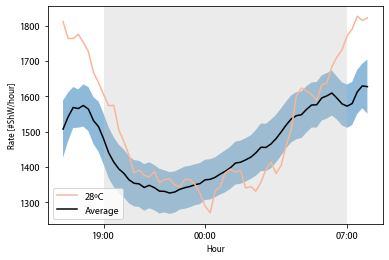

In [423]:
ax = plt.subplot()
averaged = plot_rate_all_night(ax, only_mid=True, is_legend=True)
avf = pd.DataFrame(averaged).transpose()

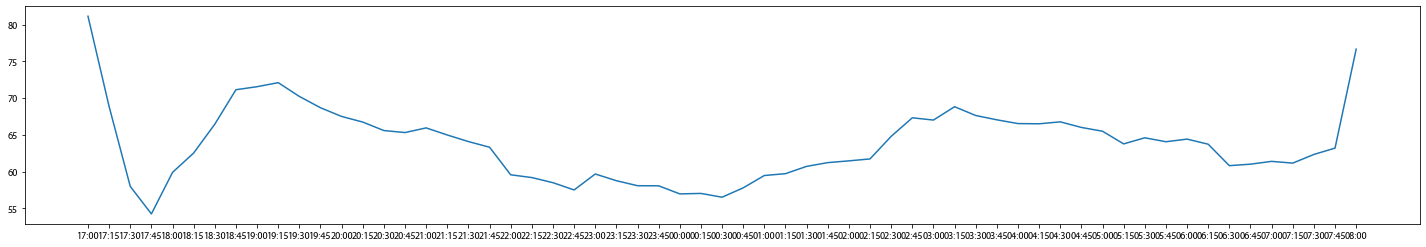

In [430]:
plt.figure(figsize=(25,4))
plt.plot(avf.sem(axis=1))

In [417]:
p = Path('/media/sil2/Data/Lizard/Stellagama/SA09_SA07/SA07_SA09_17_06_21_Trial11_Trial25_27D/Record Node 117/regev_cache/decimate_rec_SA07.mat')
animal_id = 'SA07'
rp = RecordingsParser(p.parent.parent.as_posix(), channel=None, is_debug=False, animal_id=animal_id, mat_only=True, lowpass=40)
swcl = clustering.SharpWavesClusterer(rp, window_time=0.8, cwt_wavelet='morl', is_debug=False)
swcl.train(rp.v.flatten(), rp.t, thresh=0.25, conv_w=600, mfilt=tmpl[::-1])
# swcl.plot_cycle_with_sharp_waves(102);

Ylim: 952.8050607972675


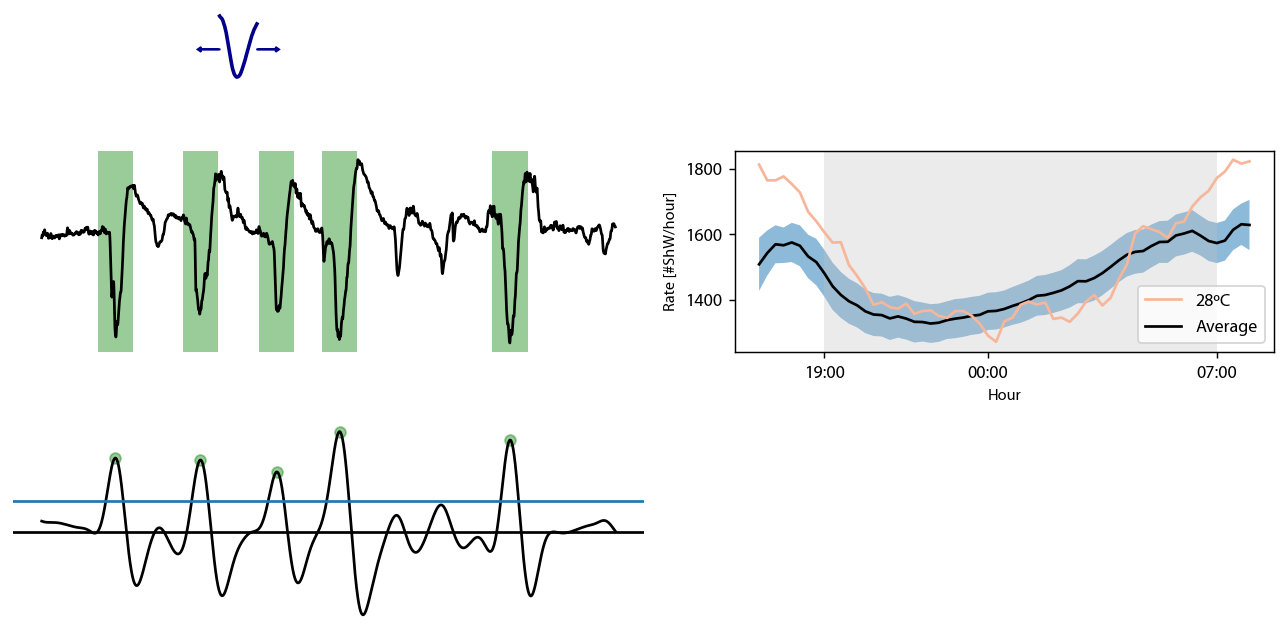

In [418]:
fig = plt.figure(tight_layout=True, figsize=(10, 5), dpi=130)
cols = 5
gs = gridspec.GridSpec(3, cols, height_ratios=[1, 3, 3], width_ratios=[1,1,1,1,6])
ax = fig.add_subplot(gs[0, 1])
c = 'darkblue'
ax.plot(tmpl, c, linewidth=2)
ax.arrow(len(tmpl),tmpl.mean(),len(tmpl)/2,0, color=c, head_width=20)
ax.arrow(0,tmpl.mean(),-len(tmpl)/2,0, color=c, head_width=20)
ax.axis('off')
swcl.plot_sharp_waves_detection(26894, 26907, fig.add_subplot(gs[1, :cols-1]), fig.add_subplot(gs[2, :cols-1]))
ax = fig.add_subplot(gs[1,cols-1])
plot_rate_all_night(ax, only_mid=True, is_legend=True)
plt.savefig('plots/supplementary.pdf')

In [263]:
gdf = []
for name, sw_df in sw_dfs.items():
    if name in bad_recordings:
        continue
    group_rate = sw_df.groupby('group').signal.count()
    group_rate /= group_rate.sum()
    group_rate = group_rate.to_dict()
    group_rate.update({'animal_id': name[0], 'name': name[1]})
    gdf.append(group_rate)

gdf = pd.DataFrame(gdf).rename(columns={1.0: 'SWS', 2.0: 'REM'})
gdf.head()

,SWS,REM,animal_id,name
0,0.570886,0.429114,SA03,SA3_10_20_21_Trial1_2021-02-10_17-17-52
1,0.737118,0.262882,SA03,SA3_12.02.21_Trial2_2021-02-12_17-35-59
2,0.658777,0.341223,SA03,SA3_Trial4_15.02.21_3.6_HOT2_2021-02-15_17-08-39
3,0.515214,0.484786,SA03,SA3_Trial6_21_02_21_3M6_24D_2021-02-21_15-04-10
4,0.511783,0.488217,SA03,SA3_Trial7_22_02_21_3M6_24D_2021-02-22_16-03-00


In [264]:
phase_db = loadmat('db_phase.mat')['pdb'].flatten()
phase_db = (phase_db - phase_db.min())/(phase_db.max()-phase_db.min())

t=29.496 , P=2.5e-68


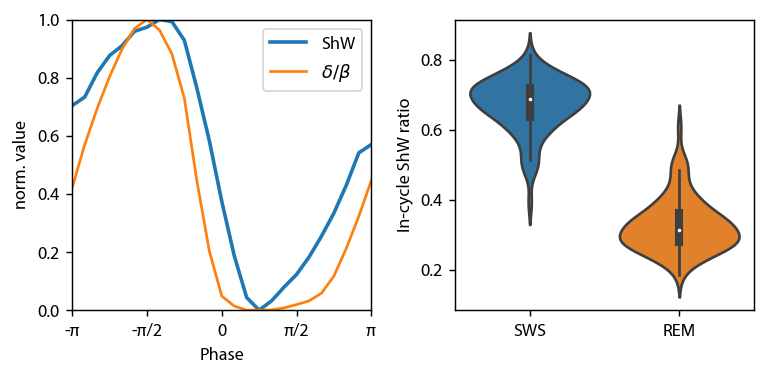

In [265]:
fig, axes = plt.subplots(1,2,dpi=130, figsize=(6,3))
t_phase, r_phase = swcl.plot_phase_shw_cycle(ax=axes[0])
axes[0].plot(t_phase, phase_db, label=r'$\delta/\beta$')
axes[0].legend()
sns.violinplot(data=gdf, ax=axes[1])
axes[1].set_ylabel('In-cycle ShW ratio')
tt, p_val = ttest_ind(gdf.SWS, gdf.REM, equal_var=False)
# axes[1].bar(['SWS', 'REM'], [gdf.SWS.mean(), gdf.REM.mean()])
# for i, row in gdf.iterrows():
#     axes[1].plot(['SWS', 'REM'], [row.SWS, row.REM], c=animal_colors[row.animal_id])
# axes[1].text('REM',0.7,f'P={p_val:.1e}', fontsize=14);
print(f't={tt:.3f} , P={p_val:.1e}')
fig.tight_layout()
plt.savefig('plots/phase.pdf')

In [176]:
p2vs = {}
for p in tqdm(mats):
    try:
        i = p.name.find('SA')
        animal_id = p.name[i:i+4]
        rec_id = -4 if p.parts[-3].startswith('Record') else -3
        rec_name = p.parts[rec_id]
        name = (animal_id, rec_name)
        rp = RecordingsParser(p.parent.parent.as_posix(), channel=None, is_debug=False, animal_id=animal_id, mat_only=True)
        for j in range(1, 50):
            pa = p.parent.parent / 'analysis' / f'Animal={animal_id},recNames=sleepNight{j}' / f'dbAutocorr_ch{rp.channel}.mat'
            if pa.exists():
                break
        S = loadmat(pa)
        p2vs[name] = S['peak2VallyDiff'][0][0]
    except ImportError as exc:
        print(f'ERROR: {p}: {exc}')

  0%|          | 0/99 [00:00<?, ?it/s]

In [901]:
m = loadmat('start_dates.mat')
m['startDates']

array([[array(['/media/sil2/Data/Lizard/Stellagama/SA3/SA3_10_20_21_Trial1_2021-02-10_17-17-52'],
              dtype='<U78')                                                                      ,
        array(['/media/sil2/Data/Lizard/Stellagama/SA3/SA3_12.02.21_Trial2_2021-02-12_17-35-59'],
              dtype='<U78')                                                                      ,
        array(['/media/sil2/Data/Lizard/Stellagama/SA3/SA3_Trial3_13.02.21_3.6_HOT_2021-02-13_16-05-23'],
              dtype='<U86')                                                                              ,
        array(['/media/sil2/Data/Lizard/Stellagama/SA3/SA3_Trial4_15.02.21_3.6_HOT2_2021-02-15_17-08-39'],
              dtype='<U87')                                                                               ,
        array(['/media/sil2/Data/Lizard/Stellagama/SA3/SA3_Trial6_21_02_21_3M6_24D_2021-02-21_15-04-10'],
              dtype='<U86')                                             

In [ ]:
# calculate the mean number of ShW per cycle for each recording
cf = pd.DataFrame()
for p in tqdm(mats):
    try:
        i = p.name.find('SA')
        animal_id = p.name[i:i+4]
        rec_id = -4 if p.parts[-3].startswith('Record') else -3
        rec_name = p.parts[rec_id]
        name = (animal_id, rec_name)
        if name not in temps or name in bad_recordings:
            continue
        rp = RecordingsParser(p.parent.parent.as_posix(), channel=None, is_debug=False, animal_id=animal_id, mat_only=True)
        sig_df = sw_dfs[name]
        temp = temps[name]
        m = sig_df.groupby('signal').start.count().rename('amount')
        s = pd.Series(rp.sc.off - rp.sc.on, name='cyc_duration')
        df = pd.concat([m, s], axis=1, join='inner')
        shw_cyc = (df.amount/df.cyc_duration).mean()
        cf = cf.append({'temp': temp, 'y': shw_cyc, 'animal_id': animal_id, 'name': name}, ignore_index=True)
    except Exception as exc:
        print(f'ERROR; {exc}; {p}')

In [ ]:
# old loop
rates = {}
all_nights = {}
temps = {}
sw_dfs = {}
for p in tqdm(mats):
    try:
        i = p.name.find('SA')
        animal_id = p.name[i:i+4]
        # if animal_id not in ['SA07']:
        #     continue
        rec_id = -4 if p.parts[-3].startswith('Record') else -3
        rec_name = p.parts[rec_id]
        name = (animal_id, rec_name)
        rp = RecordingsParser(p.parent.parent.as_posix(), channel=None, is_debug=False, animal_id=animal_id, mat_only=True, lowpass=40)
        swcl = clustering.SharpWavesClusterer(rp, window_time=0.8, cwt_wavelet='morl', is_debug=False)
        swcl.train(rp.v.flatten(), rp.t, thresh=0.25, conv_w=600, mfilt=tmpl[::-1])
        r, t, _ = swcl.calc_cycle_sw_rate(wt=20, group_length=150)
        rf = swcl.calc_sw_rate(60*60, overlap=0.75, label=None, lights_off_only=True)
        rates[name] = r
        all_nights[name] = rf
        temps[name] = rp.temp
        sw_dfs[name] = swcl.sig_df.copy()
    except Exception as exc:
        print(f'ERROR; {exc}; {p}')

temps = {k: v for k, v in sorted(temps.items(), key=lambda item: item[1])}

In [927]:
# vfunc = np.vectorize(np.squeeze)
datedf = pd.DataFrame(m['startDates'], index=['path', 'animal_id', 'start_date']).applymap(np.squeeze).transpose()
datedf = datedf[datedf.start_date.astype(bool)]
datedf.loc[:, 'start_date'] = pd.to_datetime(datedf.start_date)
datedf

,path,animal_id,start_date
0,/media/sil2/Data/Lizard/Stellagama/SA3/SA3_10_...,SA03,2021-02-10 17:17:52
1,/media/sil2/Data/Lizard/Stellagama/SA3/SA3_12....,SA03,2021-02-12 17:35:59
2,/media/sil2/Data/Lizard/Stellagama/SA3/SA3_Tri...,SA03,2021-02-13 16:05:23
3,/media/sil2/Data/Lizard/Stellagama/SA3/SA3_Tri...,SA03,2021-02-15 17:08:39
4,/media/sil2/Data/Lizard/Stellagama/SA3/SA3_Tri...,SA03,2021-02-21 15:04:10
...,...,...,...
103,/media/sil1/Stellagama/SA11_15_08_21_Trial6_20...,SA11,2021-08-15 18:23:57
104,/media/sil1/Stellagama/SA11_16_08_21_Trial7_20...,SA11,2021-08-16 18:04:53
105,/media/sil1/Stellagama/SA11_17_08_21_Trial8_20...,SA11,2021-08-17 17:00:33
106,/media/sil1/Stellagama/SA11_SA12_22_08_21_Tria...,SA11,2021-08-22 15:13:08


In [ ]:
s = pd.Series(p2vs)
animals = s.index.get_level_values(0).unique()
cols = 4
rows = int(np.ceil(len(animals)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(25, rows*4))
axes = axes.flatten()
for i, animal_id in enumerate(animals):
    axes[i].hist(s[animal_id], bins=np.arange(0,2,0.05))
    axes[i].set_title(animal_id)

In [ ]:
# p = Path('/media/sil2/Data/Lizard/Stellagama/SA07_SA06/SA07_SA05_15_05_21_Trial03_Trial30_27D/Record Node 117/regev_cache/decimate_rec_SA07.mat')
p = Path('/media/sil2/Data/Lizard/Stellagama/SA09_SA07/SA07_SA09_17_06_21_Trial11_Trial25_27D/Record Node 117/regev_cache/decimate_rec_SA07.mat')
# p = Path('/media/sil2/Data/Lizard/Stellagama/SA4/SA4_15_03_21_Trial5_3M6_24D_2021-03-15_16-11-05/regev_cache/decimate_rec_SA04.mat')
animal_id = 'SA07'
rp = RecordingsParser(p.parent.parent.as_posix(), channel=None, is_debug=False, animal_id=animal_id, mat_only=True, lowpass=40)
swcl = clustering.SharpWavesClusterer(rp, window_time=0.8, cwt_wavelet='morl', is_debug=False)
swcl.train(rp.v.flatten(), rp.t, thresh=0.15, conv_w=600, mfilt=tmpl[::-1])
# swcl.plot_cycle_with_sharp_waves(102);

In [ ]:
import scipy.optimize as opt

def fit_fwhm(t, v, ax=None):

    def gauss(x, p): # p[0]==mean, p[1]==stdev
        return 1.0/(p[1]*np.sqrt(2*np.pi)) * np.exp(-(x-p[0])**2/(2*p[1]**2))

    # Renormalize to a proper PDF
    t1 = t - t.min()
    t1 = t1 - t1.max()/2
    v1 = zscore(v)
    # Fit a guassian
    step = 0.01
    for std in np.arange(step, 2+step, step):
        p0 = [0, std] # Inital guess is a normal distribution
        errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
        p1, success = opt.leastsq(errfunc, p0[:], args=(t1, v1))
        fit_mu, fit_stdev = p1
        if success and np.abs(fit_mu) < 0.05:
            break
        if std == 2:
            print('unable to fit')
            return
    FWHM = 2*np.sqrt(2*np.log(2)) * fit_stdev
    if ax is not None:
        ax.plot(t1, v1)
        ax.plot(t1, gauss(t1, p1), lw=3, alpha=.5, color='r')
        ax.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='g', alpha=0.5)
        ax.set_title(f'{FWHM:.2}')
    return FWHM

In [ ]:
nplt = 9
fig, axes = plt.subplots(1, nplt, figsize=(25,4))
for i, row in sf.iterrows():
    t = swcl.parser.t[int(row.start):int(row.end)].flatten()
    v = swcl.parser.v[int(row.start):int(row.end)].flatten()
    if len(v) == 0:
        continue

    # fit_fwhm(t, -v, ax=axes[i])
    v = -v
    axes[i].plot(t, v)
    hmx = half_max_x(t, v)
    half = max(v)/2.0
    axes[i].plot(hmx, [half, half], 'r')
    if i >= nplt-1:
        break

<AxesSubplot:xlabel='temp', ylabel='t_cyc'>

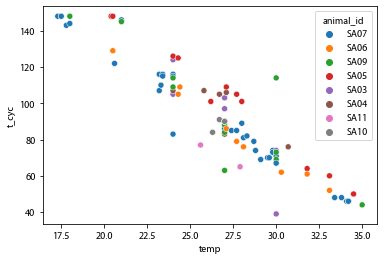

# of slow waves: 24


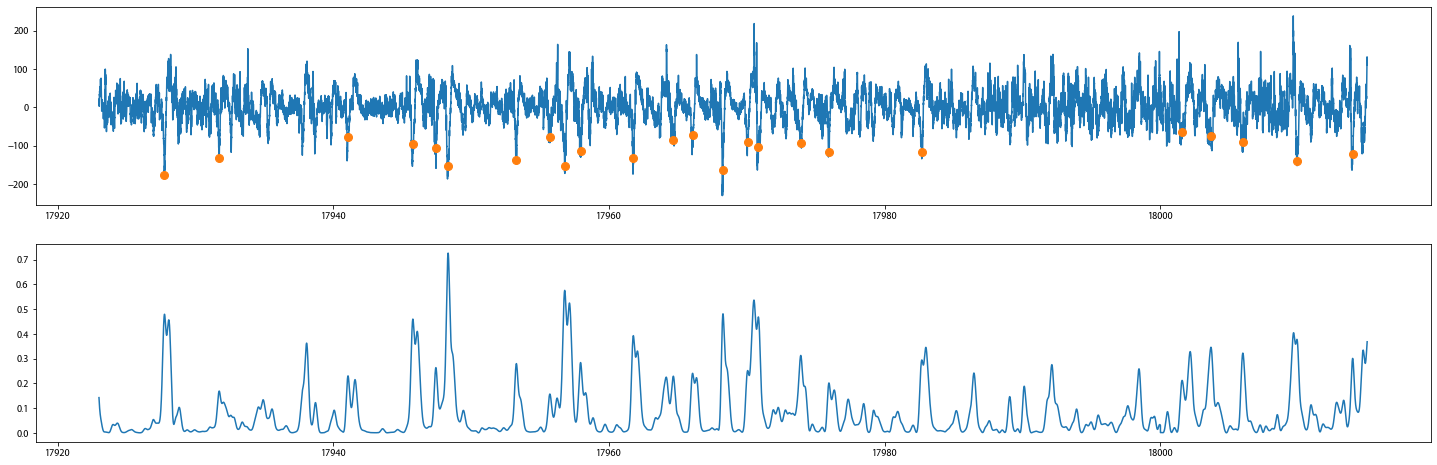

In [250]:
# p = Path('/media/sil2/Data/Lizard/Stellagama/SA3/SA3_Trial4_15.02.21_3.6_HOT2_2021-02-15_17-08-39/regev_cache/decimate_rec_SA03.mat')
# i = p.name.find('SA')
# animal_id = p.name[i:i+4]
# rp = RecordingsParser(p.parent.parent.as_posix(), channel=None, is_debug=False, animal_id=animal_id, mat_only=True)
# swcl = clustering.SharpWavesClusterer(rp, window_time=1.2, cwt_wavelet='morl', is_debug=False)
# swcl.train(rp.v.flatten(), rp.t, thresh=0.15, conv_w=500)
swcl.plot_cycle_with_sharp_waves(100, split=1);

# of slow waves: 17


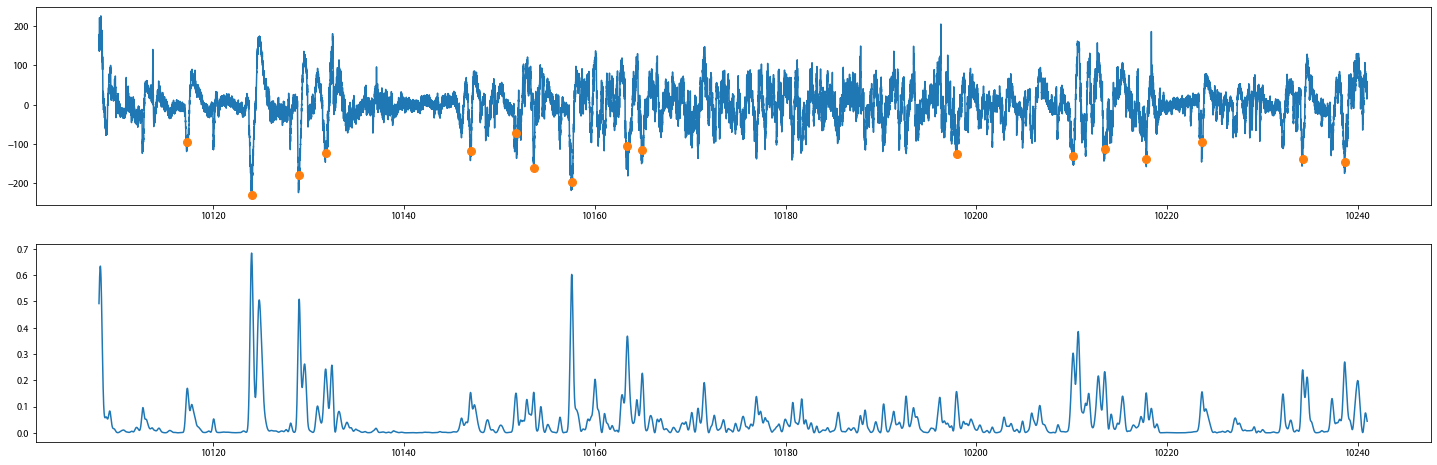

In [245]:
p = mats[-3]
i = p.name.find('SA')
animal_id = p.name[i:i+4]
rp = RecordingsParser(p.parent.parent.as_posix(), channel=None, is_debug=False, animal_id=animal_id, mat_only=True)
swcl = clustering.SharpWavesClusterer(rp, window_time=1.2, cwt_wavelet='morl', is_debug=False)
swcl.train(rp.v.flatten(), rp.t, thresh=0.15, conv_w=500)
swcl.plot_cycle_with_sharp_waves(1, split=1);

In [ ]:
p = mats[1]
i = p.name.find('SA')
animal_id = p.name[i:i+4]
rp = RecordingsParser(p.parent.parent.as_posix(), channel=None, is_debug=False, animal_id=animal_id, mat_only=True)
swcl = clustering.SharpWavesClusterer(rp, window_time=1.2, cwt_wavelet='morl', is_debug=False)
swcl.train(rp.v.flatten(), rp.t, thresh=0.15, conv_w=500)
swcl.plot_cycle_with_sharp_waves(1, split=1);

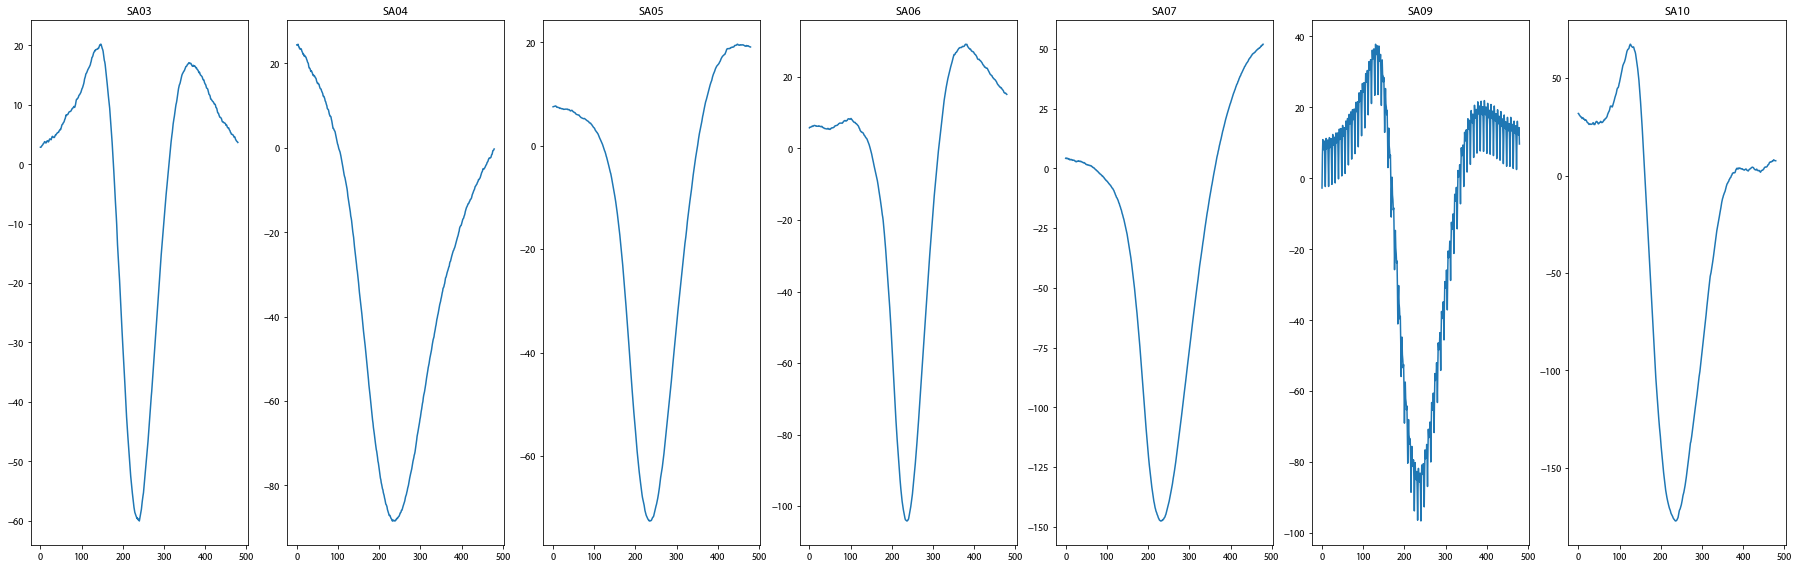

In [103]:
fig, axes = plt.subplots(1, len(shapes), figsize=(25, 8))
for i, (animal_id, S) in enumerate(shapes.copy().items()):
    shapes[animal_id] = np.vstack(S).mean(axis=0)
    axes[i].plot(shapes[animal_id].flatten())
    axes[i].set_title(animal_id)
fig.tight_layout()

In [123]:
# rates_ = {}
# temps_ = {}
for p in tqdm(mats):
    try:
        i = p.name.find('SA')
        animal_id = p.name[i:i+4]
        rec_id = -4 if p.parts[-3].startswith('Record') else -3
        rec_name = p.parts[rec_id]
        name = (animal_id, rec_name)
        if animal_id not in ['SA03', 'SA04', 'SA10']:
            continue
        rp = RecordingsParser(p.parent.parent.as_posix(), channel=None, is_debug=False, animal_id=animal_id, mat_only=True)
        swcl = clustering.SharpWavesClusterer(rp, window_time=1.2, cwt_wavelet='morl', is_debug=False)
        swcl.train(rp.v.flatten(), rp.t, thresh=0.05, conv_w=600, lowpass=4)
        r, t, _ = swcl.calc_cycle_sw_rate(wt=20, group_length=50)
        # rf = swcl.calc_sw_rate(30*60, overlap=0.75, label=None)
        rates_[name] = r
        temps_[name] = rp.temp
        # sw_dfs[name] = swcl.sig_df.copy()
    except Exception as exc:
        print(f'ERROR; {exc}; {p}')

temps_ = {k: v for k, v in sorted(temps_.items(), key=lambda item: item[1])}

  0%|          | 0/99 [00:00<?, ?it/s]

([<matplotlib.collections.PathCollection at 0x7fe0b09b1d50>], ['SA05'])

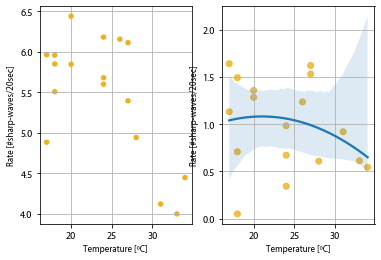

In [135]:
fig, axes = plt.subplots(1, 2)
animals = ['SA05']
plot_cycle_stats_vs_temp({k:v for k, v in temps_.items() if k[0] in animals}, {k:v for k, v in rates_.items() if k[0] in animals}, axes=axes)

In [115]:
for name, s in sw_dfs.items():
    print(f'{name}: {len(s)}')

('SA03', 'SA3_10_20_21_Trial1_2021-02-10_17-17-52'): 9998
('SA03', 'SA3_12.02.21_Trial2_2021-02-12_17-35-59'): 8555
('SA03', 'SA3_Trial3_13.02.21_3.6_HOT_2021-02-13_16-05-23'): 8177
('SA03', 'SA3_Trial4_15.02.21_3.6_HOT2_2021-02-15_17-08-39'): 12689
('SA03', 'SA3_Trial6_21_02_21_3M6_24D_2021-02-21_15-04-10'): 11582
('SA03', 'SA3_Trial7_22_02_21_3M6_24D_2021-02-22_16-03-00'): 10833
('SA03', 'SA3_Trial8_24_02_21_3M6_30Hz_30D_2021-02-24_17-31-05'): 4739
('SA03', 'SA3_Trial9_25_02_21_3M6_30Hz_30D_2021-02-25_17-20-51'): 8392
('SA04', 'SA4_11_03_21_Trial2_3M6_27D_2021-03-11_15-22-41'): 7173
('SA04', 'SA4_13_03_21_Trial4_3M6_24D_2021-03-13_15-00-52'): 4903
('SA04', 'SA4_15_03_21_Trial5_3M6_24D_2021-03-15_16-11-05'): 5726
('SA04', 'SA4_16_03_21_21_Trial6_3M6_24D-03-16_16-17-06'): 6588
('SA04', 'SA4_17_03_21_Trial7_3M6_27D_2021-03-17_16-21-59'): 4441
('SA04', 'SA4_18_03_21_Trial8_3M6_24D_2021-03-18_16-11-41'): 5763
('SA04', 'SA4_20_03_21_Trial10_3M6_30D_2021-03-20_14-37-24'): 6608
('SA04', 'SA4

In [ ]:
import tempfile
from fpdf import FPDF

pdf = FPDF()
for p in tqdm(mats):
    with tempfile.TemporaryDirectory() as tmpdirname:
        try:
            rp = RecordingsParser(p.parent.parent.as_posix(), channel=17)
            swcl = clustering.SharpWavesClusterer(rp, window_time=1.2, cwt_wavelet='morl')
            swcl.train(rp.v.flatten(), rp.t, n_clusters=3)

            fig, axes = plt.subplots(2, 1, figsize=(20, 15), dpi=100)
            swcl.plot_sw_cycle_rate(wt=20, group_length=80, ax=axes[0])
            rf = swcl.calc_sw_rate(1000, overlap=0.75, label=None)
            sns.lineplot(data=rf, x='time', y='rate', ax=axes[1])
            fig.tight_layout()
            filename = f'{tmpdirname}/{p.parts[-4]}.png'
            fig.savefig(filename)
            plt.close(fig)
            pdf.add_page()
            pdf.set_font('Times','', 12)
            w = 150; h = 110
            pdf.text(20, 20, p.parts[-4])
            pdf.image(filename, 20, 40, w, h)
        except Exception as exc:
            print(f'ERROR; {exc}; {p}')

pdf.output('slow_waves.pdf', "F")

In [ ]:
sdfs = []
for mat_path in tqdm(mats):
    try:
        rp = RecordingsParser(mat_path.parent.parent.as_posix(), channel=17)
        swcl = clustering.SharpWavesClusterer(rp, window_time=1.2, cwt_wavelet='morl')
        swcl.train(rp.v.flatten(), rp.t, n_clusters=3)
        xf = swcl.sig_df.copy()
        xf['name'] = mat_path.parts[-4]
        sdfs.append(xf)
    except Exception as exc:
        print(f'ERROR; {exc}; {mat_path.parent.parent}')

sdfs = pd.concat(sdfs)

In [143]:
def foo():
    sdfs2 = []
    for p, xf in zip(mats, sdfs):
        xf = xf.copy()
        xf['name'] = p.parts[-4]
        sdfs2.append(xf)
    return pd.concat(sdfs2)

sdf = foo()

In [7]:
root_dir

NameError: name 'root_dir' is not defined

In [13]:
brain_states.query(f'folder=="/media/sil2/Data/Lizard/Stellagama/{rec_name}"')

,Exclude,spikes,sortedManually,videoSync,Breathing,Animal,recNames,Remarks,Date,MEAfiles,...,Temp,tempMedian,accelerometerCh,Complete_recording,TempLogger_file,Temp_verifcation,video_start_time,video_end_time,AUX_data,video_triggers


In [18]:
brain_states.query(f'folder=="{p.parent.parent}"').Temp.values[0]

24.0

In [246]:
brain_states = pd.read_excel('/media/sil2/Data/Lizard/Stellagama/brainStatesSS.xlsx')
brain_states.query('Exclude!=Exclude and Animal=="SA10"')

,Exclude,spikes,sortedManually,videoSync,Breathing,Animal,recNames,Remarks,Date,MEAfiles,...,Temp,tempMedian,accelerometerCh,Complete_recording,TempLogger_file,Temp_verifcation,video_start_time,video_end_time,AUX_data,video_triggers
186,NaN,NaN,NaN,NaN,NaN,SA10,sleepNight1,accelerometer data corruput,40821.0,NaN,...,27.0,NaN,NaN,NaN,04_08_21_27D.csv,26-27,NaN,NaN,NaN,NaN
187,NaN,NaN,1.0,NaN,NaN,SA10,sleepNight1b,accelerometer data corruput,40821.0,ch1_32.bin,...,27.0,NaN,NaN,NaN,04_08_21_27D.csv,26-27,NaN,NaN,NaN,NaN
188,NaN,NaN,NaN,1.0,1.0,SA10,sleepNight2,accelerometer data corruput,50821.0,NaN,...,27.0,NaN,NaN,NaN,05_08_21_27D.csv,26-27,06:00:00,08:00:00,NaN,NaN
189,NaN,1,1.0,NaN,NaN,SA10,sleepNight2b,accelerometer data corruput,50821.0,ch1_32.bin,...,27.0,NaN,NaN,NaN,05_08_21_27D.csv,26-27,06:00:00,08:00:00,NaN,NaN
190,NaN,NaN,NaN,NaN,NaN,SA10,sleepNight3,NaN,60821.0,NaN,...,27.0,26.8,"1,2,3",NaN,06_08_21_27D.csv,26-27,NaN,NaN,NaN,NaN
191,NaN,1,1.0,NaN,NaN,SA10,sleepNight3b,NaN,60821.0,ch1_32.bin,...,27.0,26.8,"1,2,3",NaN,06_08_21_27D.csv,26-27,NaN,NaN,NaN,NaN
193,NaN,NaN,NaN,1.0,1.0,SA10,sleepNight4,NaN,70821.0,NaN,...,27.0,26.3,"1,2,3",NaN,07_08_21_27D.csv,26-27,02:55:00,05:30:00,NaN,NaN
194,NaN,1,1.0,NaN,NaN,SA10,sleepNight4b,NaN,70821.0,ch1_32.bin,...,27.0,26.3,"1,2,3",NaN,07_08_21_27D.csv,26-27,02:55:00,05:30:00,NaN,NaN
196,NaN,NaN,NaN,1.0,1.0,SA10,sleepNight5,Some noise in high pass,90821.0,NaN,...,27.0,26.7,"1,2,3",NaN,09_08_21_27D.csv,26-27,06:30:00,10:00:00,NaN,NaN
198,NaN,NaN,NaN,NaN,1.0,SA10,sleepNight6,Video times are from front view camera (109 mi...,100821.0,NaN,...,27.0,27.0,"1,2,3",NaN,10_08_21_27D.csv,26-27,04:30:00,09:00:00,NaN,NaN


In [6]:
# Functions
thresh = 0.3
cf = 1 #13     # Central spindles frequency in Hz
nc = 1 #20     # Number of oscillations in the spindles
decimate_q = 1

def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def get_events_by_wavelets(rp, cf, nc):
    wlt = morlet(rp.fs, [cf], n_cycles=nc)[0]
    analytic = np.convolve(rp.v.flatten(), wlt, mode='same')
    magnitude = np.abs(analytic)
    phase = np.angle(analytic)
    # Square and normalize the magnitude from 0 to 1 (using the min and max)
    power = np.square(magnitude)
    norm_power = (power - power.min()) / (power.max() - power.min())
    # Find supra-threshold values
    supra_thresh = np.where(norm_power >= thresh)[0]
    
    return supra_thresh

def plot_across_night(supra_thresh):
    c = consecutive(supra_thresh)
    firsts = [x[0] for x in c]
    te = rp.t[firsts]
    times = pd.to_datetime(te, unit='s')
    vls = pd.DataFrame([1]*len(times), index=times)
    vls = vls.groupby(pd.Grouper(freq='10Min')).count().reset_index().rename(columns={0: 'amount', 'index': 'hour'})
    vls['hour'] = (vls.hour - vls.hour[0]).dt.total_seconds() / 3600
    fig = plt.figure(figsize=(10, 6), dpi=100)
    vls.pipe((sns.lineplot, 'data'), x='hour', y='amount')
    plt.grid()

In [4]:
%%time
supra_thresh_sws = get_events_by_wavelets(1, 1)

CPU times: user 7 s, sys: 588 ms, total: 7.59 s
Wall time: 7.59 s


In [438]:
rp.sc.on

0       4149.0
1       4301.0
2       4508.0
3       5331.0
4       5555.0
        ...   
127    56331.0
128    56441.0
129    56633.0
130    56777.0
131    57328.0
Name: on, Length: 132, dtype: float64

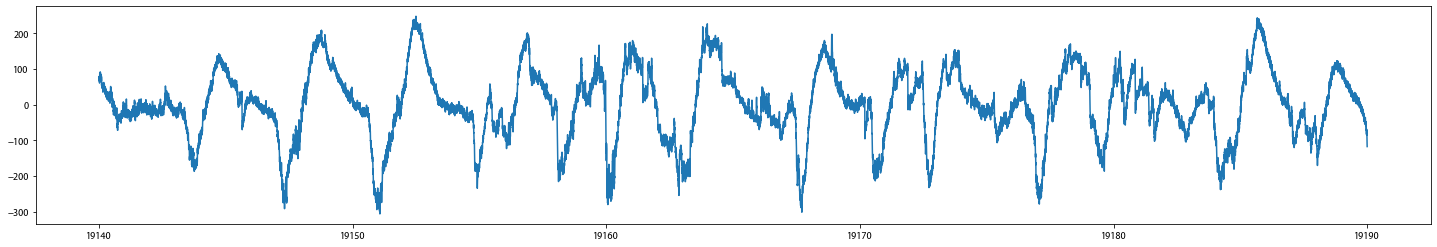

In [453]:
# Example signal
i = int(19140 * rp.fs)
duration = 50
v = rp.v[i:i+duration*int(rp.fs)].flatten()
t = rp.t[i:i+duration*int(rp.fs)].flatten()

plt.figure(figsize=(25,4))
plt.plot(t, v)

In [83]:
# Cycle example
v, t, _ = swcl.get_sleep_cycle(0)
v = v[:len(v)//5]
t = t[:len(t)//5]

# slow waves: 13


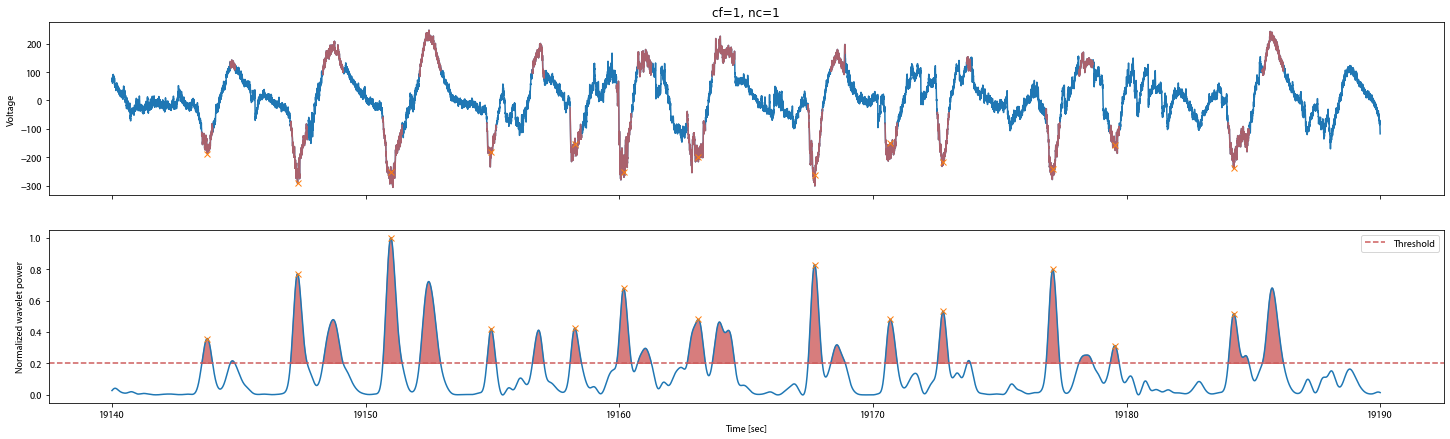

In [454]:
def plot_wavelets_conv(v, cf, nc, thresh=0.3):
    fig, axes = plt.subplots(2, 1, figsize=(25, 7), sharex=True)
    # Compute the wavelet
    wlt = morlet(rp.fs, [cf], n_cycles=nc)[0]
    # Convolve the wavelet and extract magnitude and phase
    analytic = np.convolve(v, wlt, mode='same')
    magnitude = np.abs(analytic)
    phase = np.angle(analytic)

    # Square and normalize the magnitude from 0 to 1 (using the min and max)
    power = np.square(magnitude)
    norm_power = (power - power.min()) / (power.max() - power.min())
    # Find supra-threshold values
    supra_thresh = np.where(norm_power >= thresh)[0]
    # Create vector for plotting purposes
    val_spindles = np.nan * np.zeros(v.size)
    val_spindles[supra_thresh] = v[supra_thresh]
    peaks, _ = find_peaks(norm_power, width=swcl.w/4, prominence=0.2)
    peaks = [p for p in peaks if v[p] < 0]
    print(f'# slow waves: {len(peaks)}')

    # Plot
    axes[0].plot(t, v, lw=1.5)
    axes[0].plot(t, val_spindles, color='indianred', alpha=.8)
    # ax1.set_xlim(0, times[-1])
    axes[0].set_ylabel('Voltage')
    axes[0].set_title(f'cf={cf}, nc={nc}')
    axes[0].plot(t[peaks], val_spindles[peaks], "x")
    
    axes[1].plot(t, norm_power)
    axes[1].plot(t[peaks], norm_power[peaks], "x")
    axes[1].set_xlabel('Time [sec]')
    axes[1].set_ylabel('Normalized wavelet power')
    axes[1].axhline(thresh, ls='--', color='indianred', label='Threshold')
    axes[1].fill_between(t, norm_power, thresh, where = norm_power >= thresh,
                             color='indianred', alpha=.8)
    plt.legend(loc='best')
    plt.show()
    
plot_wavelets_conv(v,1,1,thresh=0.2)

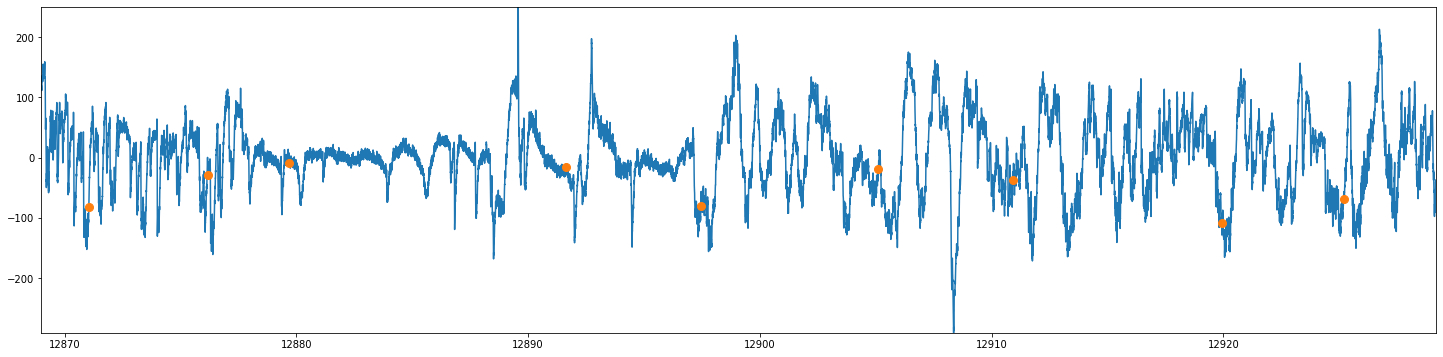

In [100]:
%matplotlib inline
from scipy.signal import find_peaks_cwt

peakind = find_peaks_cwt(-v, swcl.w*np.arange(0.8, 1.6, 0.1))
peakind = [p for p in peakind if v[p]<0]
plt.figure(figsize=(25,6))
plt.plot(t, v)
plt.plot(t[peakind], v[peakind], "o", markersize=8)
plt.margins(0,0)

In [68]:
swcl.w

480

# slow waves: 323


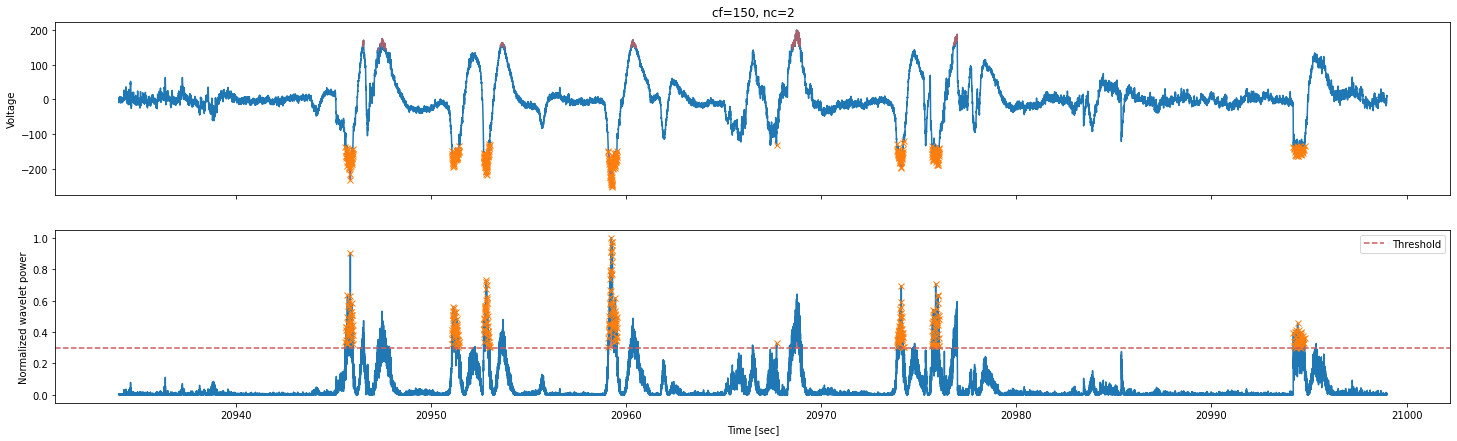

In [50]:
plot_wavelets_conv(v,150,2)

In [50]:
def get_sharp_waves(v, fs, cf, nc, w=1.5) -> np.ndarray:
    # Compute the wavelet
    wlt = morlet(fs, [cf], n_cycles=nc)[0]
    # Convolve the wavelet and extract magnitude and phase
    analytic = np.convolve(v, wlt, mode='same')
    magnitude = np.abs(analytic)
    phase = np.angle(analytic)
    # Square and normalize the magnitude from 0 to 1 (using the min and max)
    power = np.square(magnitude)
    norm_power = (power - power.min()) / (power.max() - power.min())
    # Find supra-threshold values
    supra_thresh = np.where(norm_power >= thresh)[0]
    # Create vector for plotting purposes
    val_spindles = np.nan * np.zeros(v.size)
    val_spindles[supra_thresh] = v[supra_thresh]
    peaks, _ = find_peaks(norm_power, height=thresh)
    peaks = [p for p in peaks if v[p] < 0]
    half_w = int(w*fs/2)
    return np.vstack([v[peak-half_w:peak+half_w] for peak in peaks])

def plot_wavelets_conv(v, fs, cf, nc, cols=5):
    V = get_sharp_waves(v, fs, cf, nc)
    rows = int(np.ceil(V.shape[0]/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(25,4*rows))
    axes = axes.flatten()
    for i in range(V.shape[0]):
        axes[i].plot(V[i,:])
        
DESIRED_FREQS = np.hstack([np.arange(1, 40, 2), np.array([100, 150, 200, 250])])

def get_scales(cwt_wavelet, fs):
    """Find the relevant scales to the desired frequencies"""
    f = []
    s = np.arange(1, 100000, 5)
    for i in s:
        f.append(pywt.scale2frequency(cwt_wavelet, i) * fs)

    scales = []
    for j in DESIRED_FREQS:
        i = np.argmin(np.abs(np.array(f) - j))
        scales.append(s[i])
    return sorted(list(set(scales)))
    
def cwt_feature_extraction(V, scales, wavelet):
    res = []
    for i in tqdm(range(V.shape[0])):
        v = V[i, :]
        coeffs, _ = pywt.cwt(v, scales, wavelet)
        res.append(coeffs.flatten())
    return np.vstack(res)

def run_pca(data):
    """PCA for feature reduction. Take only the PCs that sum to 95% explained variance"""
    print(f'runing PCA over {data.shape[1]} features...')
    pca = PCA(n_components=30)
    data = pca.fit_transform(data)
    c = 0
    i = -1
    for i, pc in enumerate(pca.explained_variance_ratio_):
        c += pc
        if c >= 0.97:
            break
    n_pca = i + 1
    print(f'Number of features after PCA: {n_pca}')
    data = data[:, :n_pca]
    print(f'New data shape: {data.shape}')
    return data, pca

def train_som(X, n_rows=100, n_columns=160, is_zscore=False):
    print('Start SOM train...')
    if is_zscore:
        X = zscore(X)
    som = somoclu.Somoclu(n_columns, n_rows)
    som.train(data=X)
    return som, X

def cluster_som(som, algorithm, is_plot=True):
    print('Start SOM clustering...')
    som.cluster(algorithm=algorithm)
    if is_plot:
        som.view_umatrix(bestmatches=True)
    print(f'# clusters: {len(np.unique(som.clusters))}')
    
    return som, algorithm

In [8]:
S = []
for mat_path in tqdm(mats):
    try:
        rp = RecordingsParser(mat_path.parent.parent.as_posix(), channel=17)
        supra_thresh_sws = get_sharp_waves(rp.v.flatten(), rp.fs, 1, 1)
        S.append(supra_thresh_sws)
    except Exception as exc:
        print(f'ERROR: {exc}; {mat_path}')

S = {k: v for k, v in zip([m.as_posix() for m in mats], S)}

  0%|          | 0/26 [00:00<?, ?it/s]

Loading .mat file...
Loading .mat file...
Loading .mat file...
Loading .mat file...
Loading .mat file...
Loading .mat file...
Loading .mat file...
Loading .mat file...
Loading .mat file...
Loading .mat file...
Loading .mat file...
Loading .mat file...
Loading .mat file...
Loading .mat file...
Loading .mat file...
Loading .mat file...
ERROR: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 600; /media/sil2/Data/Lizard/Stellagama/SA09_SA07/SA07_AS09_19_06_21_Trial13_Trial27_35D/Record Node 117/regev_cache/decimate_rec_ch17.mat
Loading .mat file...
ERROR: need at least one array to concatenate; /media/sil2/Data/Lizard/Stellagama/SA09_SA07/SA07_SA09_21_06_21_Trial14_Trial28_35D/Record Node 117/regev_cache/decimate_rec_ch17.mat
Loading .mat file...
Loading .mat file...
Loading .mat file...
Loading .mat file...
ERROR: all the input array dimensions for the concatenation axis 

In [102]:
from scipy.io import savemat, loadmat

savemat('shw_all.mat', shapes, do_compression=True)
# S = loadmat('slow_waves.mat')

In [56]:
sw_dfs

{'SA07_19_05_21_Trial05_27D':        signal     start       end  group
 0         NaN       407       887    NaN
 1         NaN      2945      3425    NaN
 2         NaN     10405     10885    NaN
 3         NaN     12008     12488    NaN
 4         NaN     13483     13963    NaN
 ...       ...       ...       ...    ...
 16055     NaN  23997022  23997502    NaN
 16056     NaN  23997852  23998332    NaN
 16057     NaN  23998363  23998843    NaN
 16058     NaN  23998772  23999252    NaN
 16059     NaN  23999557  24000037    NaN
 
 [16060 rows x 4 columns],
 'SA07_20_05_21_Trial06_35D':        signal     start       end  group
 0         NaN       388       868    NaN
 1         NaN      1282      1762    NaN
 2         NaN      2551      3031    NaN
 3         NaN      3895      4375    NaN
 4         NaN      4376      4856    NaN
 ...       ...       ...       ...    ...
 17090     NaN  25672133  25672613    NaN
 17091     NaN  25673601  25674081    NaN
 17092     NaN  25674590  25675

In [57]:
cols = ['start', 'end']
l = []
for name, xf in sw_dfs.items():
    l.append([name, xf[cols].to_numpy()])

m = np.array(l, dtype=object)
savemat('shw.mat', {'sw': m})

In [53]:
for k, data in S.items():
    print(f'{k}: {len(data)}')

__header__: 73
__version__: 3
__globals__: 0
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_19_05_21_Trial05_27D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 691
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_20_05_21_Trial06_35D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 4
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_21_05_21_Trial07_35D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 359
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_22_05_21_Trial08_18D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 2
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_25_05_21_Trial10_30D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 8171
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_27_05_21_Trial12_24D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 3825
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_31_05_21_Trial13_30D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 6944
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_02_06_21_Trial14_30D/Record Node 117/regev_cache/decimate_rec_ch

/home/regev/anaconda3/envs/lfp/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


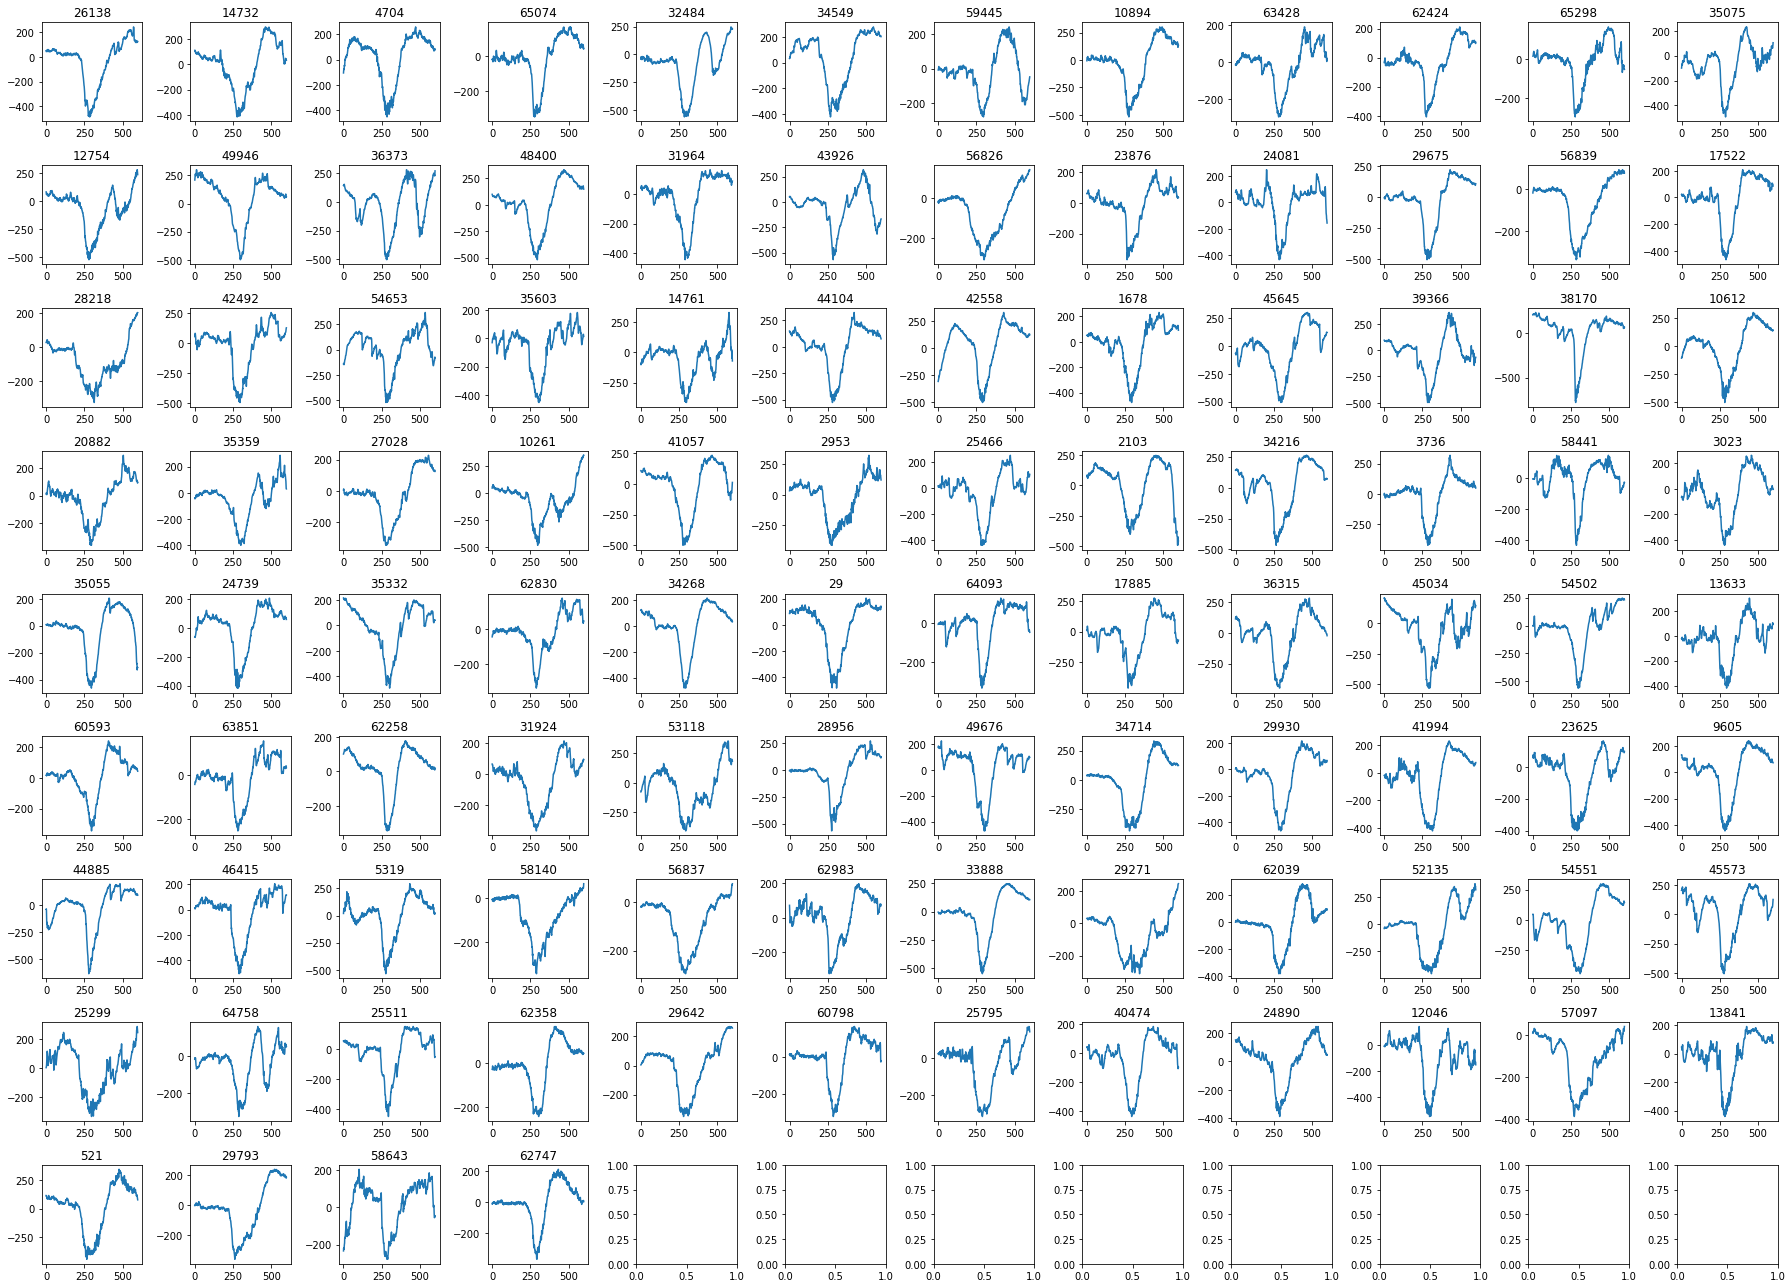

In [14]:
%matplotlib inline
s = np.vstack(S.values())
cols = 12
idx = np.random.choice(np.arange(s.shape[0]), 100)
rows = int(np.ceil(len(idx)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(25, rows*2))
axes = axes.flatten()
for i, j in enumerate(idx):
    axes[i].plot(s[j, :])
    axes[i].set_title(str(j))
fig.tight_layout()

In [23]:
V = np.vstack(list(S.values()))
print(f'V shape: {V.shape}')
cwt_wavelet = 'morl'
scales = get_scales(cwt_wavelet, rp.fs)
X = cwt_feature_extraction(V, scales, cwt_wavelet)
X_pca, pca = run_pca(X)

V shape: (65839, 600)


  0%|          | 0/65839 [00:00<?, ?it/s]

runing PCA over 7200 features...
Number of features after PCA: 23
New data shape: (65839, 23)


In [62]:
som, X_pca_zscore = train_som(X_pca, n_rows=100, n_columns=160, is_zscore=False)

Start SOM train...


Start SOM clustering...


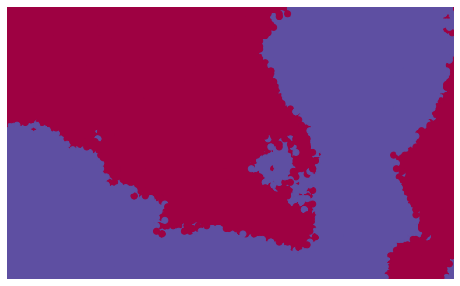

# clusters: 2
silhouette_score: 0.205


In [78]:
algorithm = KMeans(n_clusters=2, random_state=0)
# algorithm = DBSCAN(eps=0.5, min_samples=20)
# algorithm = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=100, compute_full_tree=True, compute_distances=True)
som, algo = cluster_som(som, algorithm=algorithm, is_plot=True)
labels = som.clusters[som.bmus[:, 1], som.bmus[:, 0]]
sils = silhouette_score(X_pca_zscore, labels)
print(f'silhouette_score: {sils:.3f}')

In [64]:
keys = []
sils = []
for n_clusters in tqdm(range(2, 20)):
    algorithm = KMeans(n_clusters=n_clusters, random_state=0)
    som, algo = cluster_som(som, algorithm, is_plot=False)
    labels = som.clusters[som.bmus[:, 1], som.bmus[:, 0]]
    sl = silhouette_score(X_pca_zscore, labels)
    sils.append(sl)
    keys.append(n_clusters)
    print(f'{n_clusters} - silouhuette: {sl:.3f}')

  0%|          | 0/18 [00:00<?, ?it/s]

Start SOM clustering...
# clusters: 2
2 - silouhuette: 0.205
Start SOM clustering...
# clusters: 3
3 - silouhuette: 0.190
Start SOM clustering...
# clusters: 4
4 - silouhuette: 0.158
Start SOM clustering...
# clusters: 5
5 - silouhuette: 0.143
Start SOM clustering...
# clusters: 6
6 - silouhuette: 0.133
Start SOM clustering...
# clusters: 7
7 - silouhuette: 0.123
Start SOM clustering...
# clusters: 8
8 - silouhuette: 0.114
Start SOM clustering...
# clusters: 9
9 - silouhuette: 0.112
Start SOM clustering...
# clusters: 10
10 - silouhuette: 0.104
Start SOM clustering...
# clusters: 11
11 - silouhuette: 0.102
Start SOM clustering...
# clusters: 12
12 - silouhuette: 0.099
Start SOM clustering...
# clusters: 13
13 - silouhuette: 0.098
Start SOM clustering...
# clusters: 14
14 - silouhuette: 0.097
Start SOM clustering...
# clusters: 15
15 - silouhuette: 0.091
Start SOM clustering...
# clusters: 16
16 - silouhuette: 0.090
Start SOM clustering...
# clusters: 17
17 - silouhuette: 0.091
Start SO

In [112]:
for name, data in S.items():
    print(f'{name}: {data.shape[0]}')

/media/sil2/Data/Lizard/Stellagama/SA07/SA07_19_05_21_Trial05_27D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 691
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_20_05_21_Trial06_35D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 4
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_21_05_21_Trial07_35D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 359
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_22_05_21_Trial08_18D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 2
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_25_05_21_Trial10_30D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 8171
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_27_05_21_Trial12_24D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 3825
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_31_05_21_Trial13_30D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 6944
/media/sil2/Data/Lizard/Stellagama/SA07/SA07_02_06_21_Trial14_30D/Record Node 117/regev_cache/decimate_rec_ch17.mat: 12
/media/sil2/Data/Lizard/Stellagama

In [74]:
def print_cluster_examples(V, X_pca, som, algorithm, n_examples=7):
    dists_df = pd.DataFrame(index=np.arange(X_pca.shape[0]), columns=['label', 'distance'])
    dists_df['label'] = som.clusters[som.bmus[:, 1], som.bmus[:, 0]]
    labels = sorted(dists_df.label.unique())
    fig, axes = plt.subplots(len(labels), n_examples, figsize=(25,3*len(labels)))
    for i, l in tqdm(enumerate(labels)):
        lf = dists_df.query(f'label=={l}').copy()
        for ii in lf.index:
            lf.loc[ii, 'distance'] = distance.euclidean(X_pca[ii, :], algorithm.cluster_centers_[l, :])
        idx = lf.sort_values(by='distance').index[:n_examples]
        for j, seg_id in enumerate(idx):
            axes[i, j].plot(V[seg_id, :])
            axes[i, j].set_title(seg_id)

0it [00:00, ?it/s]

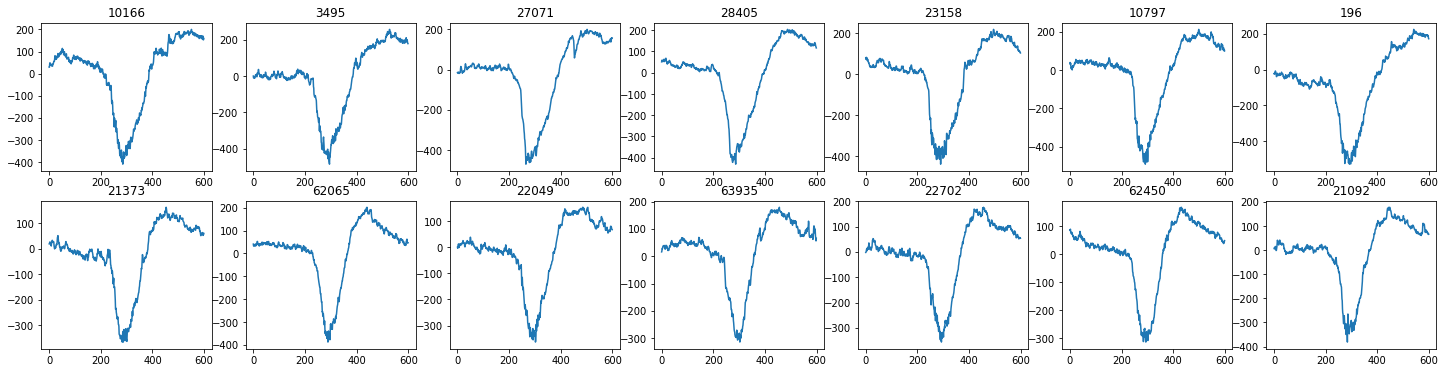

In [79]:
print_cluster_examples(V, X_pca, som, algorithm, n_examples=7)

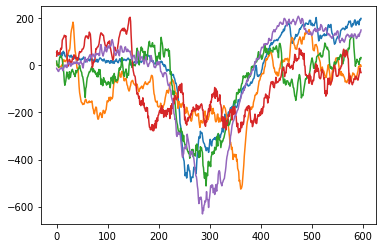

In [73]:
for i in range(5):
    plt.plot(V[i,:])

In [89]:
y = np.array(['/'.join(Path(p).parts[6:8]) for p in S.keys()])
X = np.vstack(list(S.values()))

In [100]:
X = []
y = []
for k, v in S.items():
    for i in range(v.shape[0]):
        X.append(v[i,:])
        y.append(k)
X = np.vstack(X)
y = np.vstack(y).flatten()

In [98]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [101]:
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [102]:
model = XGBClassifier()
model.fit(X_train, y_train)

[20:48:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=40,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [105]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)

In [107]:
accuracy_score(y_test, y_pred)

0.4680285540704739

In [108]:
from sklearn.model_selection import GridSearchCV

clf = XGBClassifier(
eval_metric = 'auc',
num_class = 2,
nthread = 4,
silent = 1,
)
parameters = {
    'num_boost_round': [100, 250, 500],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [6, 9, 12],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
}
clf = GridSearchCV(clf, parameters, n_jobs=10, cv=2)
clf.fit(X_train, y_train)
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
print('predicted:', clf.predict([[1,1]]))

/home/regev/anaconda3/envs/lfp/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  UserWarning,


KeyboardInterrupt: 

In [96]:
# prints memory usage
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_')
        and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('brain_states', 284979),
 ('sf', 216032),
 ('sig_df', 216032),
 ('cf', 7783),
 ('rf', 5760),
 ('all_nights', 4712),
 ('rates', 4712),
 ('sw_dfs', 4712),
 ('temps', 4712),
 ('RecordingsParser', 1472),
 ('MultiIndex', 1192),
 ('AgglomerativeClustering', 1064),
 ('DBSCAN', 1064),
 ('KMeans', 1064),
 ('PCA', 1064),
 ('mats', 992),
 ('r', 904),
 ('t', 904),
 ('DataFrame', 896),
 ('Path', 896),
 ('colors', 656),
 ('row', 483),
 ('animal_colors', 376),
 ('V', 248),
 ('x', 224),
 ('axes', 184),
 ('decimate', 144),
 ('entropy', 144),
 ('find_peaks', 144),
 ('morlet', 144),
 ('plot_cycle_stats_vs_temp', 144),
 ('plot_rate_all_night', 144),
 ('plot_sw_around_cycle_trasition', 144),
 ('plot_sw_per_cycle', 144),
 ('plot_sw_shapes', 144),
 ('print_columns', 144),
 ('remove_imported_pydev_package', 144),
 ('silhouette_score', 144),
 ('skew', 144),
 ('zscore', 144),
 ('h', 136),
 ('l', 136),
 ('p', 120),
 ('font_file', 116),
 ('font_files', 104),
 ('cycles_compare', 96),
 ('rec_name', 90),
 ('cm', 8

In [97]:
del brain_states